In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
df_all = pd.read_pickle("data.pickle")
# 初始化列为 float 类型
df_all["hour_likeCount"] = 0.0
df_all["hour_watchCount"] = 0.0

# 创建布尔索引，标识 live_time_last 不为 0 的行，避免出现0而得到无限大的数值
valid_indices = df_all["live_time_last"] != 0

# 使用布尔索引和向量化操作计算 hour_watchCount 和 hour_likeCount
df_all.loc[valid_indices, "hour_watchCount"] = (
    df_all.loc[valid_indices, "watchCount"]
    / df_all.loc[valid_indices, "live_time_last"]
) * 3600
df_all.loc[valid_indices, "hour_likeCount"] = (
    df_all.loc[valid_indices, "likeCount"] / df_all.loc[valid_indices, "live_time_last"]
) * 3600

# 输出平均值
print(df_all["hour_likeCount"].mean(), df_all["hour_watchCount"].mean())

346.223123004971 674.5854626903632


In [5]:
for column in df_all.columns:
    # 空值
    null_count = df_all[column].isnull().sum()

    # 检查字段类型是否为数值型
    if pd.api.types.is_numeric_dtype(df_all[column]):
        # 最大值
        max_value = df_all[column].max()

        # 最小值
        min_value = df_all[column].min()

        # 平均值
        mean_value = df_all[column].mean()

        # 打印字段信息
        print(f"字段名: {column}")
        print(f"空值数量: {null_count}")
        print(f"最大值: {max_value}")
        print(f"最小值: {min_value}")
        print(f"平均值: {mean_value}")
        print(f"字段类型：{type(column)}")
        print()
    else:
        print(f"字段名: {column}")
        print(f"空值数量: {null_count}")
        print("字段不是数值型，无法计算最大值、最小值和平均值")
        print(f"字段类型：{type(column)}")
        print()

字段名: liveId
空值数量: 0
字段不是数值型，无法计算最大值、最小值和平均值
字段类型：<class 'str'>

字段名: isFinish
空值数量: 0
最大值: True
最小值: False
平均值: 0.9999950775985819
字段类型：<class 'str'>

字段名: isFull
空值数量: 0
最大值: True
最小值: False
平均值: 0.938876695690376
字段类型：<class 'str'>

字段名: parentArea
空值数量: 0
字段不是数值型，无法计算最大值、最小值和平均值
字段类型：<class 'str'>

字段名: area
空值数量: 0
字段不是数值型，无法计算最大值、最小值和平均值
字段类型：<class 'str'>

字段名: coverUrl
空值数量: 0
字段不是数值型，无法计算最大值、最小值和平均值
字段类型：<class 'str'>

字段名: danmakusCount
空值数量: 0
最大值: 275257
最小值: 0
平均值: 1189.399399343967
字段类型：<class 'str'>

字段名: startDate
空值数量: 0
最大值: 1715780200000
最小值: 1580867858000
平均值: 1677069047865.2517
字段类型：<class 'str'>

字段名: stopDate
空值数量: 0
最大值: 1715786365542
最小值: 1580869911000
平均值: 1677080696244.3796
字段类型：<class 'str'>

字段名: title
空值数量: 0
字段不是数值型，无法计算最大值、最小值和平均值
字段类型：<class 'str'>

字段名: totalIncome
空值数量: 0
最大值: 9210992.4
最小值: 0.0
平均值: 779.8671695022778
字段类型：<class 'str'>

字段名: watchCount
空值数量: 0
最大值: 554220
最小值: 0
平均值: 1725.0120389632684
字段类型：<class 'str'>

字段名: likeCount
空值数量: 0
最大值: 2

In [6]:
df_all["month"] = df_all["start_live_time"].dt.to_period("D").dt.to_timestamp()
# 去掉23年9月后的数据
filter_date_high = pd.to_datetime("2023-09-01")
filter_date_low = pd.to_datetime("2022-09-01")
df_all_after_timesplit = df_all[
    (df_all["start_live_time"] <= filter_date_high)
    & (df_all["start_live_time"] >= filter_date_low)
]

## 发现很多异常数据：有些主播的收入过高，原因是礼物数量计数错误

解决办法

- 根据主播名分组
- 四分位检测
- zscore
- log化
- 中位数填充

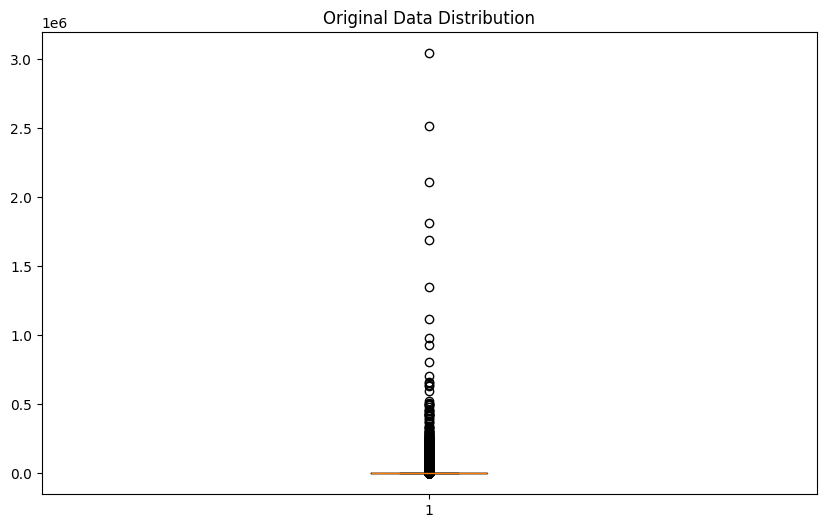

C:\Users\棒\AppData\Local\Temp\ipykernel_1636\1688440073.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'log_{column}'] = np.log(df[column] + 1)
C:\Users\棒\AppData\Local\Temp\ipykernel_1636\1688440073.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['z_score'] = np.abs(stats.zscore(df[column]))


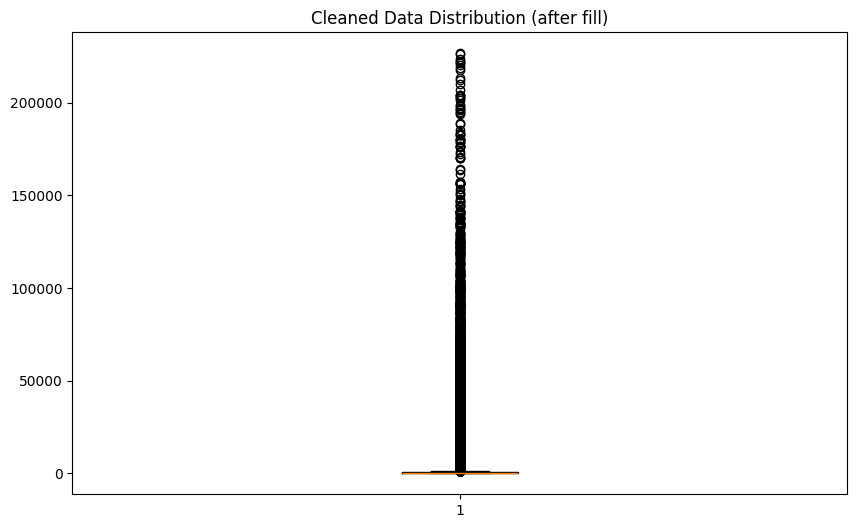

In [7]:
import pandas as pd
import numpy as np
from scipy import stats


# 定义对数据进行对数变换的函数
def log_transform(df, column):
    df[f"log_{column}"] = np.log(df[column] + 1)
    return df


# IQR方法检测异常值
def detect_outliers_iqr(df, column, outlier_thresh=3.0):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - outlier_thresh * IQR
    upper_bound = Q3 + outlier_thresh * IQR
    iqr_outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return iqr_outliers


# Z-score方法检测异常值
def detect_outliers_zscore(df, column, z_thresh=3):
    df["z_score"] = np.abs(stats.zscore(df[column]))
    z_outliers = df[df["z_score"] > z_thresh]
    return z_outliers


# 结合IQR和Z-score两种方法检测异常值
def detect_outliers_combined(df, column, iqr_thresh=1.5, z_thresh=3):
    df = log_transform(df, column)
    iqr_outliers = detect_outliers_iqr(df, f"log_{column}", iqr_thresh)
    z_outliers = detect_outliers_zscore(df, f"log_{column}", z_thresh)

    combined_outliers_index = iqr_outliers.index.intersection(z_outliers.index)
    return df.loc[combined_outliers_index]


# 绘制数据分布图
def plot_data_distribution(df, column, title):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.boxplot(df[column])
    plt.show()


# 主方法：检测异常值并绘制分布图，补偿被删除的数据
def analyze_and_plot(data, column):
    # 原始数据分布
    plot_data_distribution(data, column, "Original Data Distribution")

    # 检测异常值
    outliers = detect_outliers_combined(data, column)

    # 计算清洗后的中位数
    cleaned_data = data.drop(outliers.index)
    fill_value = cleaned_data[column].median()

    # 填充被删除的数据
    data.loc[outliers.index, column] = fill_value

    # 清洗后数据分布
    cleaned_data_after_fill = data
    plot_data_distribution(
        cleaned_data_after_fill, column, "Cleaned Data Distribution (after fill)"
    )

    return outliers, cleaned_data_after_fill


# 执行函数
outliers, cleaned_data = analyze_and_plot(df_all_after_timesplit, "totalIncome")

In [8]:
# 随机打乱数据集
# cdr表示cleaned_data_ramdom
cdr = cleaned_data.sample(frac=1)

1400189    15862.741
404542     12691.573
15175       4121.120
1118880    10351.187
734727      3610.147
             ...    
1092428     6085.264
1232511     8687.457
1329162     7420.874
617491      9226.734
474126      5427.776
Name: live_time_last, Length: 731569, dtype: float64
1400189   2023-01-04 22:38:52
404542    2023-05-27 20:31:07
15175     2023-06-16 10:32:35
1118880   2023-05-09 18:13:37
734727    2023-02-22 20:44:40
                  ...        
1092428   2023-02-16 11:13:39
1232511   2023-05-18 21:41:19
1329162   2022-09-27 15:16:13
617491    2023-04-01 15:53:13
474126    2023-01-15 15:57:03
Name: start_live_time, Length: 731569, dtype: datetime64[ns]
1400189   2023-01-05 03:03:14.741
404542    2023-05-28 00:02:38.573
15175     2023-06-16 11:41:16.120
1118880   2023-05-09 21:06:08.187
734727    2023-02-22 21:44:50.147
                    ...          
1092428   2023-02-16 12:55:04.264
1232511   2023-05-19 00:06:06.457
1329162   2022-09-27 17:19:53.874
617491    2023-04-0

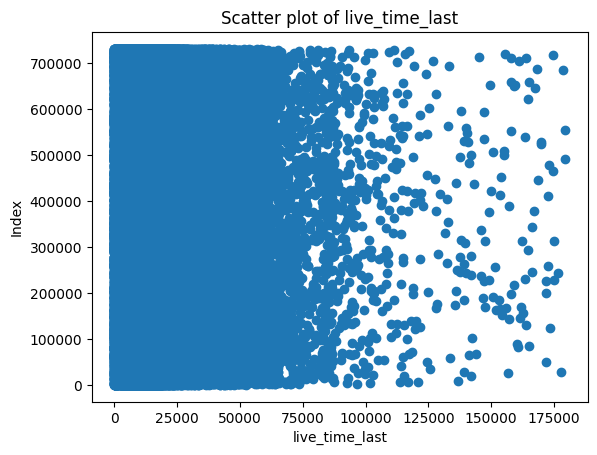

In [9]:
print(cdr["live_time_last"])
print(cdr["start_live_time"])
print(cdr["stop_live_time"])
import matplotlib.pyplot as plt

plt.scatter(cdr["live_time_last"], range(len(cdr)))
plt.ylabel("Index")
plt.xlabel("live_time_last")
plt.title("Scatter plot of " + "live_time_last")
plt.show()

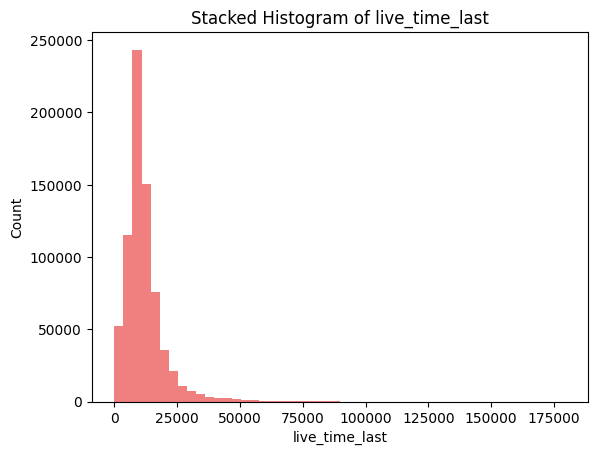

In [10]:
import matplotlib.pyplot as plt

plt.hist(cdr["live_time_last"], bins=50, stacked=True, color="lightcoral")
plt.xlabel("live_time_last")
plt.ylabel("Count")
plt.title("Stacked Histogram of " + "live_time_last")
plt.show()

In [11]:
max_row = df_all.loc[df_all["live_time_last"].idxmax()]
print(max_row)

liveId                                       b41e2dfb-38ef-44b2-961c-dd418c6740d0
isFinish                                                                     True
isFull                                                                       True
parentArea                                                                   未知分区
area                                                                         未知分区
coverUrl                        https://i0.hdslb.com/bfs/live/new_room_cover/a...
danmakusCount                                                                1086
startDate                                                           1607500025000
stopDate                                                            1607679948000
title                                                                      =w= 惬意
totalIncome                                                                 14.56
watchCount                                                                    163
likeCount       

然而不可思议的是这个直播了将近五十个小时的数据居然不是异常值

<img src="https://p1.meituan.net/csc/73979ac50715ef6c47e9952f9f6b925a5275328.png" width="1280" height="700">

（弹幕数据也是可查的）https://laplace.live/stats/2362016/b41e2dfb-38ef-44b2-961c-dd418c6740d0

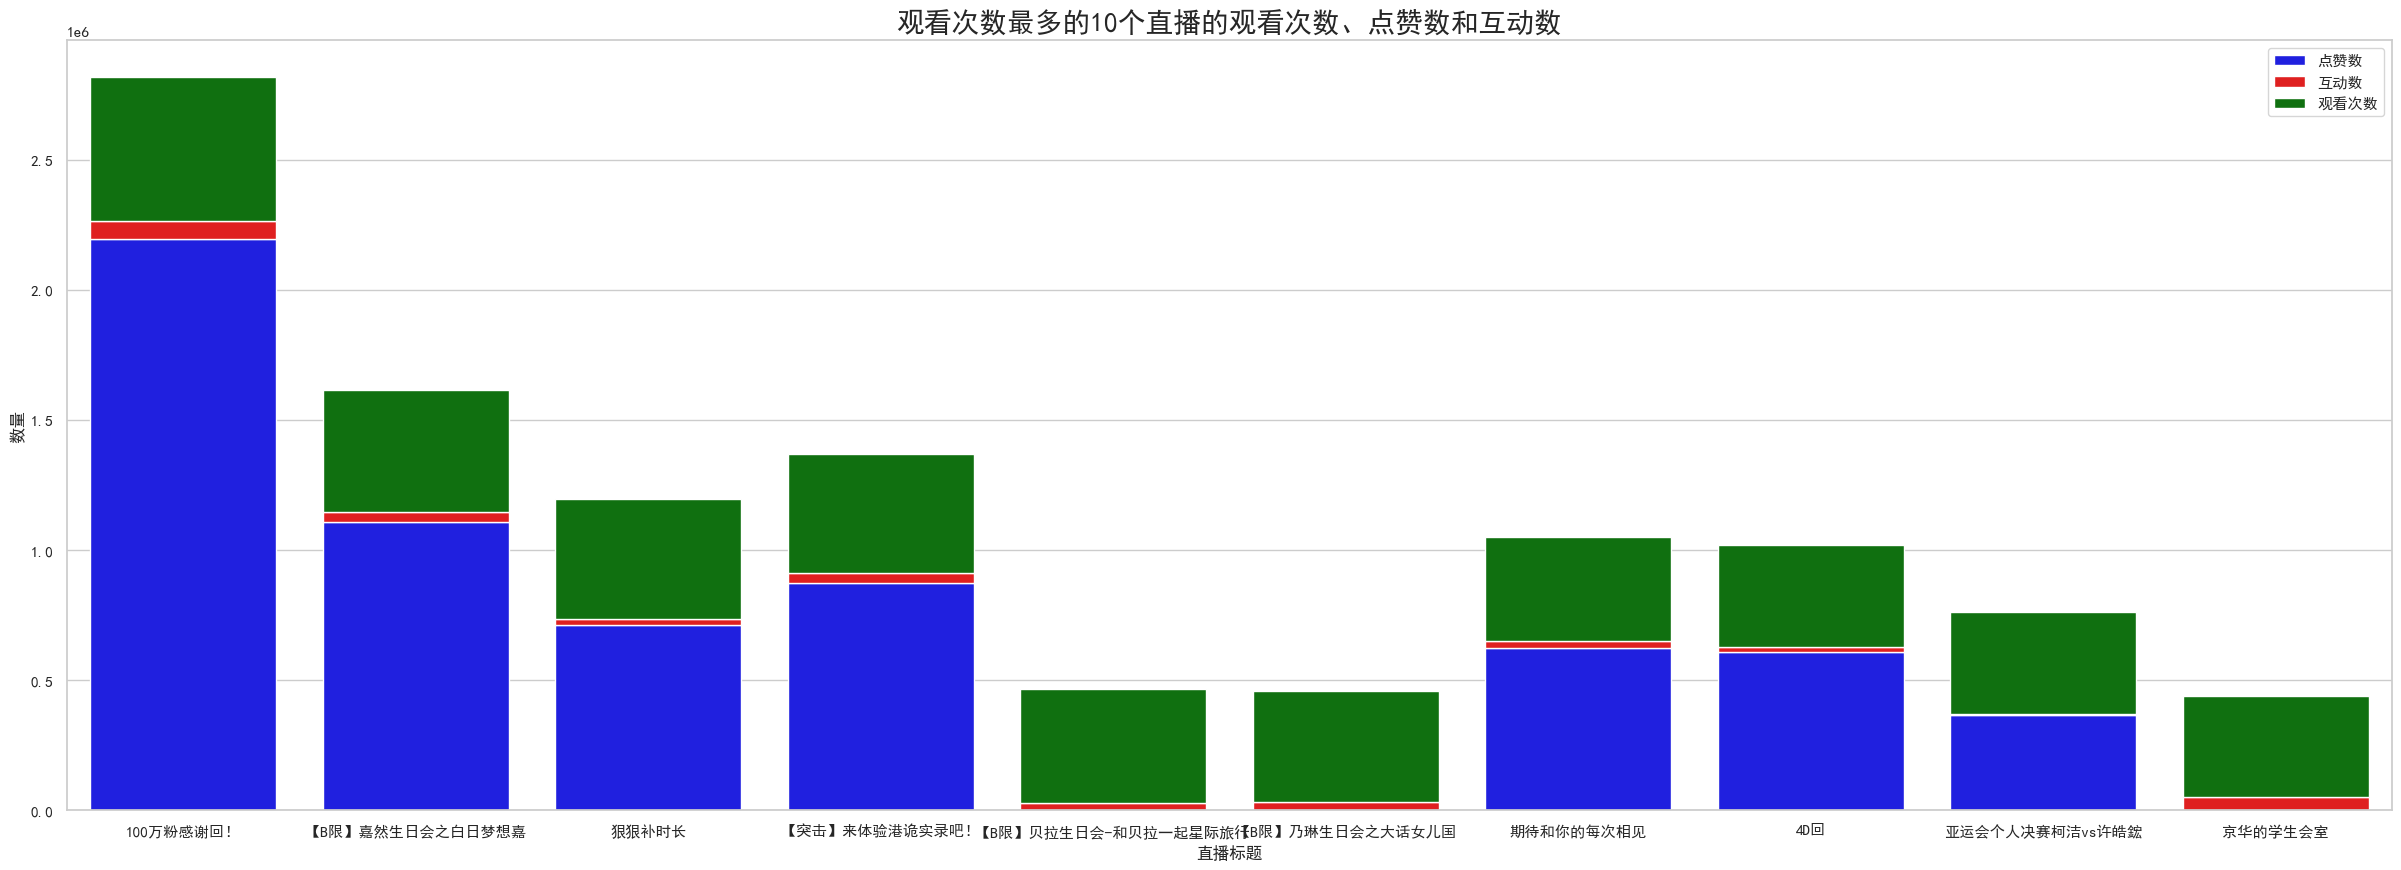

In [12]:
import seaborn as sns

# 创建一个新的Dataframe
data = {
    "watchCount": [
        554220,
        470168,
        460906,
        455222,
        439796,
        428792,
        402579,
        394542,
        391258,
        385719,
    ],
    "likeCount": [2195076, 1107738, 711368, 875781, 0, 0, 623268, 610691, 368025, 0],
    "interactionCount": [
        68146,
        37063,
        24083,
        37911,
        28412,
        31417,
        25889,
        15556,
        3664,
        52309,
    ],
    "title": [
        "100万粉感谢回！",
        "【B限】嘉然生日会之白日梦想嘉",
        "狠狠补时长",
        "【突击】来体验港诡实录吧！",
        "【B限】贝拉生日会-和贝拉一起星际旅行",
        "【B限】乃琳生日会之大话女儿国",
        "期待和你的每次相见",
        "4D回",
        "亚运会个人决赛柯洁vs许皓鋐",
        "京华的学生会室",
    ],
}
df = pd.DataFrame(data)

# 设置风格
sns.set_theme(style="whitegrid")
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

# 开始绘图
plt.figure(figsize=(30, 10))
plt.title("观看次数最多的10个直播的观看次数、点赞数和互动数", fontsize=20)

# 创建堆叠的条形图
sns.barplot(x="title", y="likeCount", data=df, color="blue", label="点赞数")
sns.barplot(
    x="title",
    y="interactionCount",
    data=df,
    color="red",
    bottom=df.likeCount,
    label="互动数",
)
sns.barplot(
    x="title",
    y="watchCount",
    data=df,
    color="green",
    bottom=df.likeCount + df.interactionCount,
    label="观看次数",
)

# 设置图例和标签
plt.legend()
plt.xlabel("直播标题")
plt.ylabel("数量")
plt.show()

In [13]:
grouped_df = cdr.groupby("channel_uName")[
    ["watchCount", "likeCount", "interactionCount", "totalIncome"]
]
grouped_df_sum = grouped_df.sum()
grouped_df_sum = grouped_df_sum.reset_index()

sorted_by_watchCount = grouped_df_sum.sort_values(by="watchCount", ascending=False)
sorted_by_likeCount = grouped_df_sum.sort_values(by="likeCount", ascending=False)
sorted_by_interactionCount = grouped_df_sum.sort_values(
    by="interactionCount", ascending=False
)
sorted_by_totalIncome = grouped_df_sum.sort_values(by="totalIncome", ascending=False)

print("观看数排行")
print(sorted_by_watchCount.head(20))
print()
print("点赞数排行")
print(sorted_by_likeCount.head(20))
print()
print("互动数排行")
print(sorted_by_interactionCount.head(20))
print()
print("收益排行")
print(sorted_by_totalIncome.head(20))

观看数排行
       channel_uName  watchCount  likeCount  interactionCount  totalIncome
67           Asaki大人    62756955   50642746           5271496    6990651.4
96              C酱です    56062194   13466812           4654911    3409497.7
2667            永雏塔菲    28564760    8085451           2082525    2070374.9
3241   眞白花音_Official    27960934   16337503           2161242    3074388.0
343           hanser    21894471   29778963           1931384    1206690.3
4303        阿梓从小就很可爱    19921140    4711862           1863785    2446835.3
380        shourei小N    17861366    9469728            963827     875190.8
2890       烛灵儿Hikari    17245130    8045256           1016704    3419293.4
468        七海Nana7mi    15562459    3281937           1130156    3207856.8
4317           阿萨Aza    13950521   33432910           2672075    6695969.8
4559  鲸鱼娘西丝特official    13163291   14981911            909080     952260.8
2283            月隐空夜    12690620    1792517            646509     711149.2
4391    雫るる_Officia

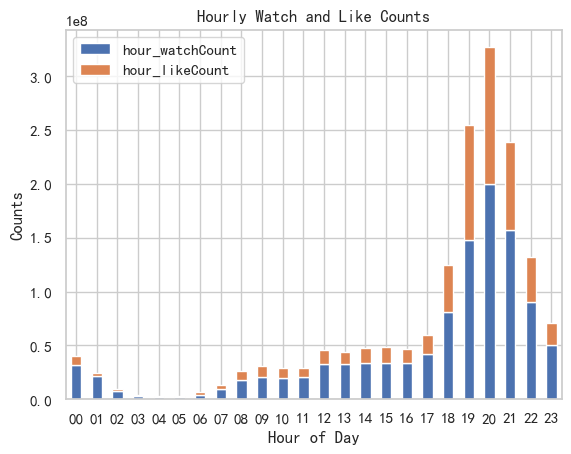

In [14]:
cdr["start_live_time"] = pd.to_datetime(cdr["start_live_time"])
df_all["stop_live_time"] = pd.to_datetime(df_all["stop_live_time"])

# 提取小时部分
df_all["hour"] = df_all["start_live_time"].dt.strftime("%H")

# 使用小时进行分组，并计算hour_watchCount和hour_likeCount的总值
hourly_totals = df_all.groupby("hour").agg(
    {"hour_watchCount": "sum", "hour_likeCount": "sum"}
)
hourly_totals.plot(kind="bar", stacked=True)
# 添加标题和标签
plt.title("Hourly Watch and Like Counts")
plt.xlabel("Hour of Day")
plt.ylabel("Counts")
plt.xticks(rotation=0)
plt.show()

In [15]:
grouped = (
    df_all.groupby(["channel_uId", "channel_uName"])
    .agg({"totalIncome": "sum", "title": "count"})
    .reset_index()
)

# 计算每个主播每次直播的平均收益
grouped["avgIncomePerLive"] = grouped["totalIncome"] / grouped["title"]
grouped.rename(columns={"title": "live_times"}, inplace=True)
grouped_sorted = grouped.sort_values(by="avgIncomePerLive", ascending=False)
print("——————————直播效益前二十————————————")
print(grouped_sorted.head(20))

——————————直播效益前二十————————————
      channel_uId     channel_uName  totalIncome  live_times  avgIncomePerLive
3970   1589583375       蕾娅-官方WACTOR   2920190.60          11     265471.872727
4161   1775966996   Vox_EN_Official   2737588.00          15     182505.866667
3983   1601895109    shoto_official   1666245.80          15     111083.053333
4054   1673137696  Luca_EN_Official    327653.30           4      81913.325000
3247    672328094           嘉然今天吃什么  17551122.26         261      67245.679157
3920   1544125954    Mysta_Official    249274.10           4      62318.525000
556       2294686         晓曦Asahino   1309326.20          25      52373.048000
3248    672342685           乃琳Queen  10486802.56         217      48326.279078
3250    672353429            贝拉kira  10254179.30         219      46822.736530
3249    672346917             向晚大魔王   9082166.40         218      41661.313761
2331    351609538           珈乐Carol   2171191.42          69      31466.542319
2644    441315555     

<Axes: xlabel='parentArea'>

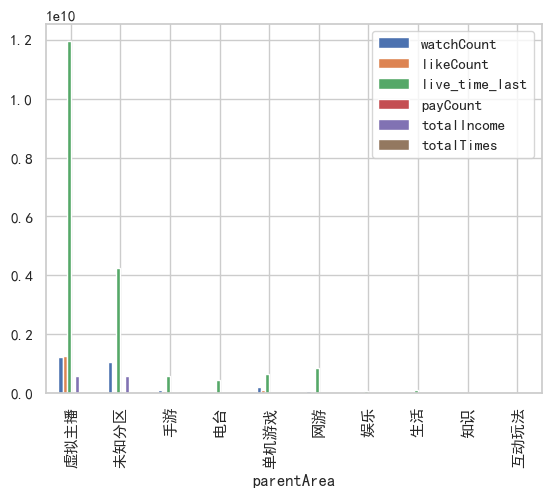

In [16]:
grouped_area = df_all.groupby("parentArea").agg(
    {
        "watchCount": "sum",
        "likeCount": "sum",
        "live_time_last": "sum",
        "payCount": "sum",
        "totalIncome": "sum",
        "channel_roomId": "count",
    }
)
grouped_area.rename(columns={"channel_roomId": "totalTimes"}, inplace=True)
grouped_area_sorted = grouped_area.sort_values(by="totalIncome", ascending=False)
plt.rcParams["font.sans-serif"] = ["SimHei"]
grouped_area_sorted[0:10].plot(kind="bar")

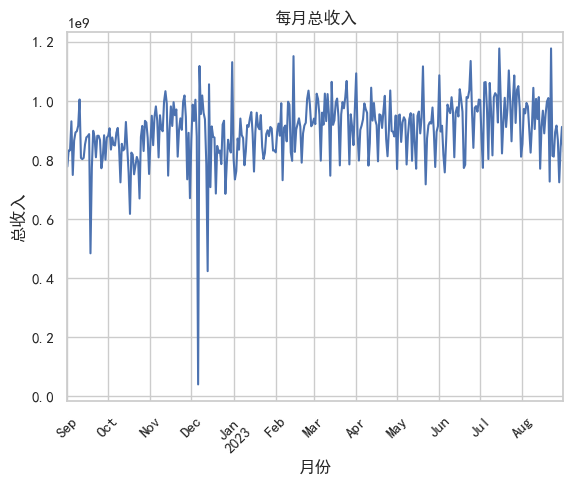

In [17]:
grouped_month = cdr.groupby("month").agg({"channel_totalIncome": "sum"})

# new_grouped_sorted = new_grouped.sort_values(by = 'channel_totalIncome', ascending=False)
# print(new_grouped_sorted)
grouped_month.plot(kind="line", legend=False)
plt.title("每月总收入")
plt.xlabel("月份")
plt.ylabel("总收入")
plt.grid(True)
plt.xticks(rotation=45)  # 旋转横轴标签以提高可读性
plt.show()

In [18]:
print(cdr.columns)

Index(['liveId', 'isFinish', 'isFull', 'parentArea', 'area', 'coverUrl',
       'danmakusCount', 'startDate', 'stopDate', 'title', 'totalIncome',
       'watchCount', 'likeCount', 'payCount', 'interactionCount',
       'maxOnlineCount', 'code', 'message', 'channel_uId', 'channel_uName',
       'channel_roomId', 'channel_faceUrl', 'channel_frameUrl',
       'channel_isLiving', 'channel_title', 'channel_tags',
       'channel_lastLiveDate', 'channel_lastLiveDanmakuCount',
       'channel_totalDanmakuCount', 'channel_totalIncome',
       'channel_totalLiveCount', 'channel_totalLiveSecond', 'channel_addDate',
       'channel_commentCount', 'channel_lastLiveIncome', 'start_live_time',
       'stop_live_time', 'live_time_last', 'hour_likeCount', 'hour_watchCount',
       'month', 'log_totalIncome', 'z_score'],
      dtype='object')


# 数据挖掘思路
## 字段解释

带-的不用管

|字段|解释|
|:--:|:--:|
|liveId|直播id|
|isFinish|-| 
|isFull|-|
|parentArea|主分区|
|area|子分区|
|coverUrl|-|
|danmakusCount|本场弹幕数|
|startDate|本场开始时间|
|stopDate|本场结束时间|
|title|本场直播标题|
|totalIncome|本场直播收入|
|watchCount|本场观看数|
|likeCount|本场点赞数（22年9月才开始记录）|
|payCount|本场礼物数|
|interactionCount|本场互动数|
|maxOnlineCount|本场最高在线人数|
|code|-|
|message|-|
|channel_uId|主播uid|
|channel_uName|主播名|
|channel_roomId|直播房间号|
|channel_faceUrl|-|
|channel_frameUrl|-|
|channel_isLiving|-|
|channel_title|频道标题|
|channel_tags|频道tag|
|channel_lastLiveDate|主播上次开播时间|
|channel_lastLiveDanmakuCount|主播上次弹幕数|
|channel_totalDanmakuCount|主播弹幕总数|
|channel_totalIncome|主播总收入|
|channel_totalLiveCount|主播总场次|
|channel_totalLiveSecond|主播总时长|
|channel_addDate|最初开播时间|
|channel_commentCount|频道总评论数|
|channel_lastLiveIncome|主播上次直播收入|
|start_live_time|本场开始时间（和上面那个格式不同）|
|stop_live_time|本场结束时间|
|live_time_last|本场时长|
|hour_likeCount|本场平均每小时点赞|
|hour_watchCount|本场平均每小时观看|
|month|本场所在年月|
|log_totalIncome|对数化的本场收入|
|z_score|-|
|hour|本场开播时间（24小时制）|

## 无监督

### 聚类算法

选一个合适（给出所有算法的结果，选一个效果好的）的聚类算法对所有数据记录聚类（算法+评价指标）。这个聚类直接聚就完了，意义只是怎么解释聚类完的结果，因为这个聚类是不带监督指标的

### 关联规则

分两步走：
- 本场数据指标的关联
- 频道/主播指标关联
（意思是要把这些分开做，因为一个主播有多场直播，不过本场数据指标可能可以考虑频道指标，这个得试试）

把非数值型的字段先二元化，再做分析

想办法指定前后项（问问gpt吧，理论上可以把除了收入之外的字段标注为输入与输出（可能要考虑加不加id），收入这样的标为仅输入）

## 带监督

### 分类算法

分类机特别多（这里包括了神经网络），但是可以根据一套标准来进行评价（f值，混淆矩阵，roc曲线和auc值）

朴素贝叶斯，KNN，决策树，逻辑回归，网上一查一大堆

先构造一个合理的监督指标y，建议复制一下上面的所有字段解释问一下gpt（可以试试多搞几个y，相当于找不同的角度，每个y做一次）

再挑X（最好不要一次放完所有字段）

### 回归

很多分类机有回归功能，比如crt这种，所以不用专门弄，但是要在分类算法里注明哪些是y用的是回归

### 文本

先弄完上面的再说吧。。。


## 聚类算法——K-means

In [19]:
# 从 cdr 中随机抽取一万条记录
sample_cdr = cdr.sample(n=100000, random_state=42)

# 输出抽样后的数据集大小
print(sample_cdr.head(3))

# 可选：保存抽样后的数据集到文件
# sample_cdr.to_csv('sample_cdr.csv', index=False)  # 将抽样后的数据集保存到 CSV 文件中，不保存行索引

                                       liveId  isFinish  isFull parentArea  \
1016417  8a8ab34c-6a85-4161-bbdf-42d1bf3d53ef      True    True       虚拟主播   
536807   3dd38674-7319-4959-a591-5e801422d00e      True    True       未知分区   
324157   4632d4d4-9620-49ea-8706-0ce0947a3cdd      True    True       虚拟主播   

         area                                           coverUrl  \
1016417  虚拟主播  https://i0.hdslb.com/bfs/live/new_room_cover/0...   
536807   未知分区  https://i0.hdslb.com/bfs/live/new_room_cover/0...   
324157   虚拟主播  https://i0.hdslb.com/bfs/live/new_room_cover/c...   

         danmakusCount      startDate       stopDate         title  ...  \
1016417            880  1670588677000  1670600124906  元气杂谈~轻松快乐聊聊天  ...   
536807             134  1662441990000  1662450056042       既来之，则派之  ...   
324157              17  1664893786000  1664903610214     【店长】开始工作！  ...   

         channel_commentCount  channel_lastLiveIncome     start_live_time  \
1016417                     0       

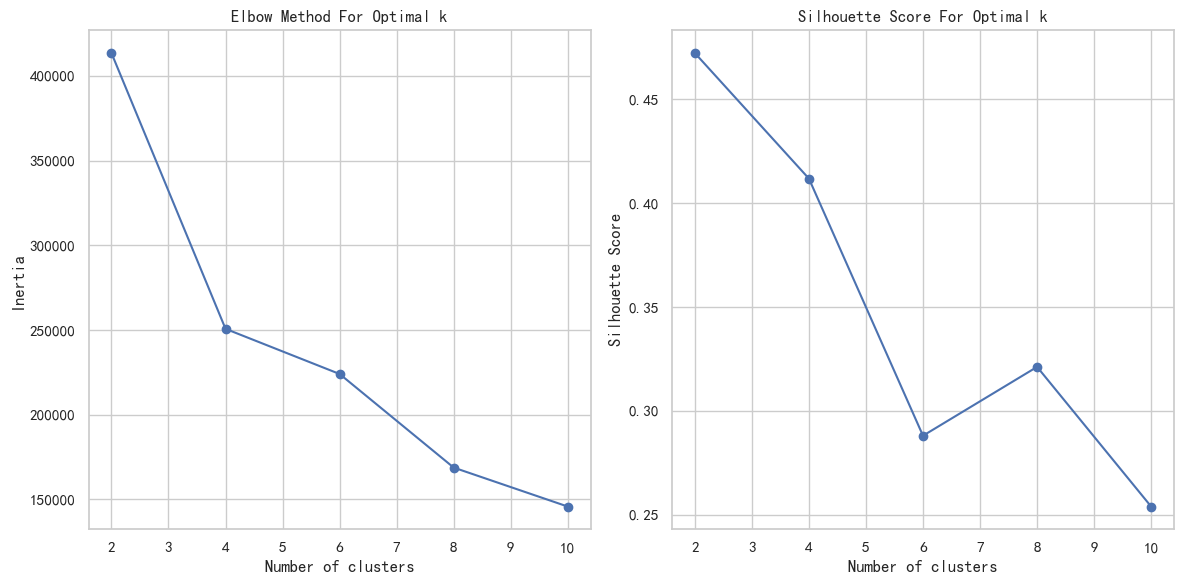

In [23]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 选择用于聚类的字段（所有数值型字段）
features = [
    "channel_totalDanmakuCount",
    "channel_totalIncome",
    "channel_totalLiveCount",
    "channel_totalLiveSecond",
    "channel_commentCount",
]

# 2. 提取特征数据
X = sample_cdr[features].dropna()  # 去掉包含缺失值的行

# 3. 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. 使用肘部法则确定最佳聚类数
inertia = []
silhouette_scores = []
K = range(2, 11, 2)  # 减少迭代次数，增加步长
for k in K:
    kmeans = MiniBatchKMeans(
        n_clusters=k, random_state=42, batch_size=100
    )  # 使用 MiniBatchKMeans
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# 绘制肘部法则图
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, "bo-")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method For Optimal k")

# 绘制轮廓系数图
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, "bo-")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score For Optimal k")

plt.tight_layout()
plt.show()

Optimal number of clusters: 2
                                      liveId  isFinish  isFull parentArea  \
552641  73f86363-0fc0-4422-b395-8c4f228e6c9d      True    True       虚拟主播   
670074  13b4aab8-6797-485b-a8e2-31d0dda4197a      True    True       虚拟主播   
700148  ab9fbf29-dc6b-4511-85a1-719ac948e02c      True    True       虚拟主播   
832896  0b8282ae-e29e-4f4e-a3dc-c38f300d4332      True    True       虚拟主播   
151184  fb121df0-42a9-40dd-862f-e51b9ee59b22      True    True       虚拟主播   

            area                                           coverUrl  \
552641   虚拟Gamer  https://i0.hdslb.com/bfs/live/new_room_cover/d...   
670074      虚拟主播  https://i0.hdslb.com/bfs/live/new_room_cover/0...   
700148  虚拟Singer  https://i0.hdslb.com/bfs/live/new_room_cover/e...   
832896      虚拟主播  https://i0.hdslb.com/bfs/live/new_room_cover/3...   
151184      虚拟主播  https://i0.hdslb.com/bfs/live/user_cover/c3603...   

        danmakusCount      startDate       stopDate               title  ...  \


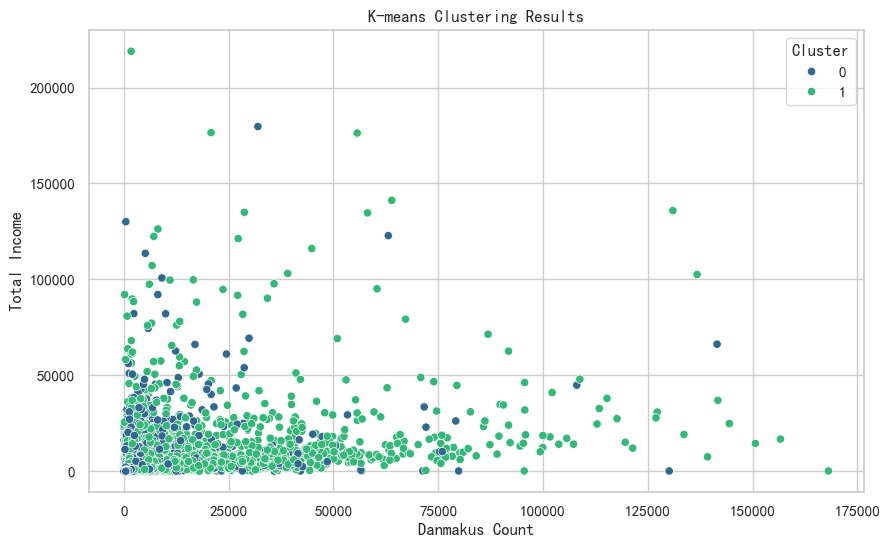

In [24]:
# 5. 选择合适的聚类数并进行K-means聚类
optimal_k = K[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal number of clusters: {optimal_k}")

kmeans = MiniBatchKMeans(n_clusters=optimal_k, random_state=42, batch_size=100)
kmeans.fit(X_scaled)

# 6. 获取聚类标签
labels = kmeans.labels_

# 7. 将聚类标签添加到原数据框中，但不保存到文件
sample_cdr["cluster"] = labels  # 只给没有缺失值的行添加聚类标签

# 8. 在Jupyter Notebook中展示结果
# 展示前5行聚类结果
print(sample_cdr.head())

# 可视化聚类结果
# 这里以 'danmakusCount' 和 'totalIncome' 为例
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="danmakusCount",
    y="totalIncome",
    hue="cluster",
    data=sample_cdr,
    palette="viridis",
)
plt.title("K-means Clustering Results")
plt.xlabel("Danmakus Count")
plt.ylabel("Total Income")
plt.legend(title="Cluster")
plt.show()

## 聚类算法——DBSCAN

                                      liveId  isFinish  isFull parentArea  \
552641  73f86363-0fc0-4422-b395-8c4f228e6c9d      True    True       虚拟主播   
670074  13b4aab8-6797-485b-a8e2-31d0dda4197a      True    True       虚拟主播   
700148  ab9fbf29-dc6b-4511-85a1-719ac948e02c      True    True       虚拟主播   
832896  0b8282ae-e29e-4f4e-a3dc-c38f300d4332      True    True       虚拟主播   
151184  fb121df0-42a9-40dd-862f-e51b9ee59b22      True    True       虚拟主播   

            area                                           coverUrl  \
552641   虚拟Gamer  https://i0.hdslb.com/bfs/live/new_room_cover/d...   
670074      虚拟主播  https://i0.hdslb.com/bfs/live/new_room_cover/0...   
700148  虚拟Singer  https://i0.hdslb.com/bfs/live/new_room_cover/e...   
832896      虚拟主播  https://i0.hdslb.com/bfs/live/new_room_cover/3...   
151184      虚拟主播  https://i0.hdslb.com/bfs/live/user_cover/c3603...   

        danmakusCount      startDate       stopDate               title  ...  \
552641             96  1691448

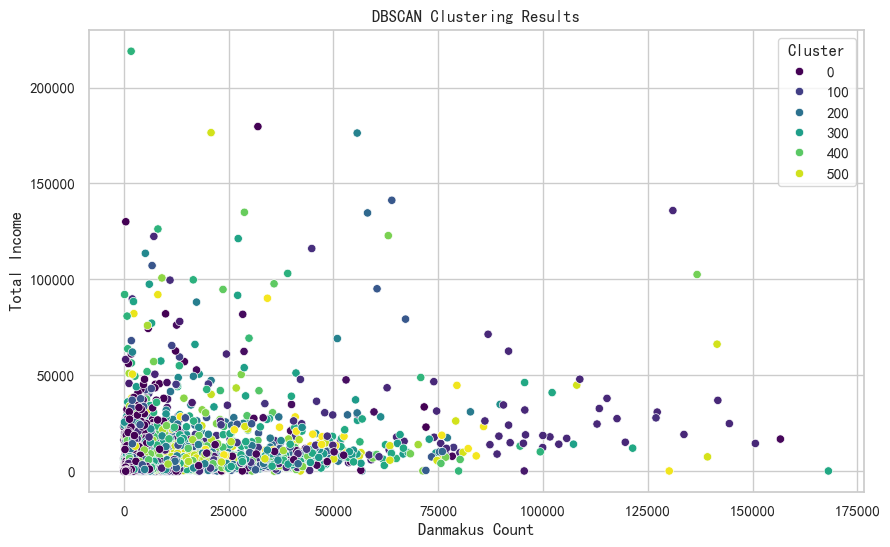

In [25]:
from sklearn.cluster import DBSCAN

# 选择用于聚类的字段（选择最重要的特征）
features = [
    "channel_totalDanmakuCount",
    "channel_totalIncome",
    "channel_totalLiveCount",
    "channel_totalLiveSecond",
    "channel_commentCount",
]

# 提取特征数据
X = sample_cdr[features].dropna()  # 去掉包含缺失值的行

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 调整 DBSCAN 参数
eps = 0.1  # 减小邻域半径
min_samples = 3  # 减小最小样本数

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(X_scaled)

# 获取聚类标签
labels = dbscan.labels_

# 将聚类标签添加到原数据框中，但不保存到文件
sample_cdr["cluster"] = labels  # 只给没有缺失值的行添加聚类标签

# 展示前5行聚类结果
print(sample_cdr.head())

# 可视化聚类结果
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="danmakusCount",
    y="totalIncome",
    hue="cluster",
    data=sample_cdr,
    palette="viridis",
)
plt.title("DBSCAN Clustering Results")
plt.xlabel("Danmakus Count")
plt.ylabel("Total Income")
plt.legend(title="Cluster")
plt.show()

## 聚类算法——层次聚类

In [26]:
from sklearn.cluster import AgglomerativeClustering

# 选择用于聚类的字段（选择最重要的特征）
features = [
    "danmakusCount",
    "totalIncome",
    "likeCount",
    "payCount",
    "interactionCount",
    "maxOnlineCount",
]

# 提取特征数据
X = sample_cdr[features].dropna()  # 去掉包含缺失值的行

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 使用层次聚类
n_clusters = 3  # 聚类数

hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
hierarchical.fit(X_scaled)

# 获取聚类标签
labels = hierarchical.labels_

# 将聚类标签添加到原数据框中
sample_cdr["cluster"] = labels  # 只给没有缺失值的行添加聚类标签

# 在Jupyter Notebook中展示结果
# 展示前5行聚类结果
print(sample_cdr.head())

# 可视化聚类结果
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="danmakusCount",
    y="totalIncome",
    hue="cluster",
    data=sample_cdr,
    palette="viridis",
)
plt.title("Hierarchical Clustering Results")
plt.xlabel("Danmakus Count")
plt.ylabel("Total Income")
plt.legend(title="Cluster")
plt.show()

## 关联分析

收入作为前项,先探讨总体收入


In [32]:
from sklearn.preprocessing import MultiLabelBinarizer
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

cdr_all = sample_cdr[
    [
        "channel_totalDanmakuCount",
        "channel_totalIncome",
        "channel_totalLiveCount",
        "channel_totalLiveSecond",
        "channel_commentCount",
    ]
]

# 替换缺失值为特定值（这里使用均值）
cdr_filled = cdr_all.fillna(cdr_all.mean())

# 选择用于关联分析的指标（这里将收入作为前项）
association_features = [
    "channel_totalDanmakuCount",
    "channel_totalLiveCount",
    "channel_totalLiveSecond",
    "channel_commentCount",
]

# 将数据转换成适合进行关联分析的格式
# 针对每个指标，将其值映射为0或1，表示出现或未出现
mlb = MultiLabelBinarizer()
cdr_binarized = mlb.fit_transform(cdr_filled[association_features].map(str))

# 将二进制数据转换为DataFrame
cdr_df = pd.DataFrame(cdr_binarized, columns=mlb.classes_)

# 使用Apriori算法找出频繁项集
frequent_itemsets = apriori(cdr_df, min_support=0.1, use_colnames=True)

# 根据频繁项集生成关联规则
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

# 输出关联规则
print(rules)

C:\Scoop\apps\miniconda3-py311\current\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


        antecedents                              consequents  \
0               (D)                                      (C)   
1               (C)                                      (_)   
2               (_)                                      (C)   
3               (a)                                      (C)   
4               (C)                                      (a)   
...             ...                                      ...   
7867506      (_, S)     (a, i, L, t, c, o, h, v, n, e, d, l)   
7867507      (l, d)     (a, i, L, t, c, o, h, v, n, e, S, _)   
7867508      (_, d)     (a, i, L, t, c, o, h, v, n, e, S, l)   
7867509         (S)  (a, i, L, t, c, o, h, v, n, e, d, l, _)   
7867510         (d)  (a, i, L, t, c, o, h, v, n, e, S, l, _)   

         antecedent support  consequent support  support  confidence  \
0                      0.25                0.75     0.25        1.00   
1                      0.75                1.00     0.75        1.00   
2              

收入作为后项，探讨单次收入

In [36]:
# 替换缺失值为特定值（例如均值）
cdr_once = sample_cdr[
    [
        "danmakusCount",
        "totalIncome",
        "watchCount",
        "payCount",
        "interactionCount",
        "maxOnlineCount",
        "channel_lastLiveDate",
        "channel_lastLiveDanmakuCount",
        "channel_totalDanmakuCount",
        "channel_totalIncome",
        "channel_totalLiveCount",
        "channel_totalLiveSecond",
        "channel_commentCount",
        "channel_lastLiveIncome",
        "hour_likeCount",
        "hour_watchCount",
        "hour",
    ]
]
cdr_filled = cdr_once.dropna()
# 将所有非布尔值或非整数列转换为布尔值（0或1）
cdr_filled = (cdr_filled != 0) & (cdr_filled != 1)

# 选择用于关联分析的目标特征
association_features = ["totalIncome"]

# 提取用于关联分析的特征
association_data = cdr_filled[association_features]

# 使用Apriori算法进行关联分析
frequent_itemsets = apriori(association_data, min_support=0.1, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# 显示关联规则
print(rules)

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction, zhangs_metric]
Index: []


## 分类算法

In [18]:
sample_cdr_x = sample_cdr[
    [
        "parentArea",
        "danmakusCount",
        "watchCount",
        "likeCount",
        "payCount",
        "interactionCount",
        "maxOnlineCount",
        "channel_lastLiveDanmakuCount",
        "channel_totalDanmakuCount",
        "channel_totalIncome",
        "channel_totalLiveCount",
        "channel_totalLiveSecond",
        "channel_commentCount",
        "channel_lastLiveIncome",
        "hour_likeCount",
        "hour_watchCount",
        "totalIncome",
        "hour",
    ]
]
print(sample_cdr_x.head(1))
pd.options.mode.copy_on_write = True
sample_cdr_x["hour"] = sample_cdr_x["hour"].astype(float)
# sample_cdr_x['log_totalIncome'] = sample_cdr_x['log_totalIncome'].astype(int)
print(sample_cdr_x.dtypes)

       parentArea  danmakusCount  watchCount  likeCount  payCount  \
777840         网游              2          15          0         0   

        interactionCount  maxOnlineCount  channel_lastLiveDanmakuCount  \
777840                 2               0                             0   

        channel_totalDanmakuCount  channel_totalIncome  \
777840                       1220                561.0   

        channel_totalLiveCount  channel_totalLiveSecond  channel_commentCount  \
777840                      79                   915064                     0   

        channel_lastLiveIncome  hour_likeCount  hour_watchCount  totalIncome  \
777840                     0.0             0.0         4.000326          0.0   

       hour  
777840   20  
parentArea                       object
danmakusCount                     int64
watchCount                        int64
likeCount                         int64
payCount                          int64
interactionCount                  int64
max

### 将parentArea二元化，并未接下来的分类算法做准备

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc,
)
from sklearn.preprocessing import KBinsDiscretizer, label_binarize
from matplotlib.colors import ListedColormap
import warnings
from itertools import cycle

warnings.filterwarnings("ignore")

# 二元化parentArea列
sample_cdr_x = pd.get_dummies(sample_cdr_x, columns=["parentArea"])

classifiers = {
    "GaussianNB": GaussianNB(),
    "CRT": DecisionTreeClassifier(criterion="gini", random_state=42, max_depth=None),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "MLPClassifier": MLPClassifier(
        hidden_layer_sizes=(100,), activation="relu", solver="adam", random_state=42
    ),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNeighborsClassifier": KNeighborsClassifier(n_neighbors=5),
}


# 定义训练和评估分类器的函数
def train_evaluate_classifier(_classifiers, variable_name, strategy="quantile"):
    for classifier_name, classifier in _classifiers.items():
        # 对目标变量进行等频分箱,先取对数再加一，用KBinsDiscretizer进行分箱
        sample_cdr_x[f"{variable_name}_bin"] = KBinsDiscretizer(
            n_bins=5, encode="ordinal", strategy=strategy
        ).fit_transform(sample_cdr_x[[variable_name]])
        print(sample_cdr_x[f"{variable_name}_bin"].sort_values().unique())
        _X = sample_cdr_x.drop(
            [f"{variable_name}_bin", variable_name], axis=1
        )  # 特征变量
        _y = sample_cdr_x[f"{variable_name}_bin"]  # 目标变量
        X_train, X_test, y_train, y_test = train_test_split(
            _X, _y, test_size=0.2, random_state=42
        )
        # 训练分类器
        classifier.fit(X_train, y_train)
        # 使用测试集进行预测
        y_pred = classifier.predict(X_test)
        # 计算准确率
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy of {classifier_name}:", accuracy)
        # 计算其他评估指标
        print(f"Classification report for {classifier_name}:")
        print(classification_report(y_test, y_pred))
        # 计算混淆矩阵并将其打印出来
        cm = confusion_matrix(y_test, y_pred)
        print(f"Confusion Matrix for {classifier_name}:")
        print(cm)

        # # 决定分箱数量，例如将值分为5个箱子
        # bins = 5

        # # 将混淆矩阵的值平展并通过np.percentile进行等频分箱
        # cm_flattened = cm.flatten()
        # percentiles = np.percentile(cm_flattened, np.arange(0, 100, 100/bins))

        # # 构建一个新的cm映射，值为其所在的箱子索引
        # cm_binned = np.digitize(cm, percentiles)

        # # 为分箱创建colormap，这里举例使用5个颜色
        # colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF']
        # custom_cmap = ListedColormap(colors[:bins])

        plt.figure(figsize=(10, 7))

        # 使用`cm_binned`和自定义colormap绘制混淆矩阵
        sns.heatmap(
            cm,
            annot=cm,
            fmt="d",
            cmap="Set3",
            linewidths=0.5,
            linecolor="black",
            square=True,
            annot_kws={"size": 16},
            xticklabels=[
                f"{variable_name}_bin_0",
                f"{variable_name}_bin_1",
                f"{variable_name}_bin_2",
                f"{variable_name}_bin_3",
                f"{variable_name}_bin_4",
            ],
            yticklabels=[
                f"{variable_name}_bin_0",
                f"{variable_name}_bin_1",
                f"{variable_name}_bin_2",
                f"{variable_name}_bin_3",
                f"{variable_name}_bin_4",
            ],
        )
        plt.title("Confusion Matrix with Equi-frequency Binning")
        plt.ylabel("Actual Class")
        plt.xlabel("Predicted Class")

        plt.show()
        # 计算 ROC AUC 分数
        n_classes = len(np.unique(y_test))

        # 首先需要将标签二值化
        y_test_binarized = label_binarize(y_test, classes=range(n_classes))

        # 获取每个类别的预测概率
        # 对于每个类，所需的预测概率是 "属于该类的概率"
        y_prob = classifier.predict_proba(X_test)

        # 计算每个类的ROC曲线和AUC值
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # 计算微平均ROC曲线和AUC值
        fpr["micro"], tpr["micro"], _ = roc_curve(
            y_test_binarized.ravel(), y_prob.ravel()
        )
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # 为了计算宏平均ROC曲线和AUC值，先聚合所有FPRs
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # 再通过插值计算所有的ROC曲线在这一点上的TPR
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        # 取平均值并计算AUC
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        # 绘制所有的ROC曲线
        plt.figure()
        lw = 2
        colors = cycle(["aqua", "darkorange", "cornflowerblue", "green", "red"])
        for i, color in zip(range(n_classes), colors):
            plt.plot(
                fpr[i],
                tpr[i],
                color=color,
                lw=lw,
                label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
            )

        plt.plot(
            fpr["micro"],
            tpr["micro"],
            label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
            color="deeppink",
            linestyle=":",
            linewidth=4,
        )

        plt.plot(
            fpr["macro"],
            tpr["macro"],
            label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
            color="navy",
            linestyle=":",
            linewidth=4,
        )

        plt.plot([0, 1], [0, 1], "k--", lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Some extension of Receiver operating characteristic to multi-class")
        plt.legend(loc="lower right")
        plt.show()

### 把maxOnlineCount作为y

[0. 1. 2. 3. 4.]
Accuracy of GaussianNB: 0.9399
Classification report for GaussianNB:
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97     19339
         1.0       0.33      0.01      0.02       504
         2.0       0.05      0.36      0.09       110
         3.0       0.00      0.00      0.00        30
         4.0       0.13      0.41      0.19        17

    accuracy                           0.94     20000
   macro avg       0.30      0.35      0.26     20000
weighted avg       0.96      0.94      0.94     20000

Confusion Matrix for GaussianNB:
[[18746    10   537    13    33]
 [  343     5   155     0     1]
 [   52     0    40     8    10]
 [    5     0    21     0     4]
 [    1     0     9     0     7]]


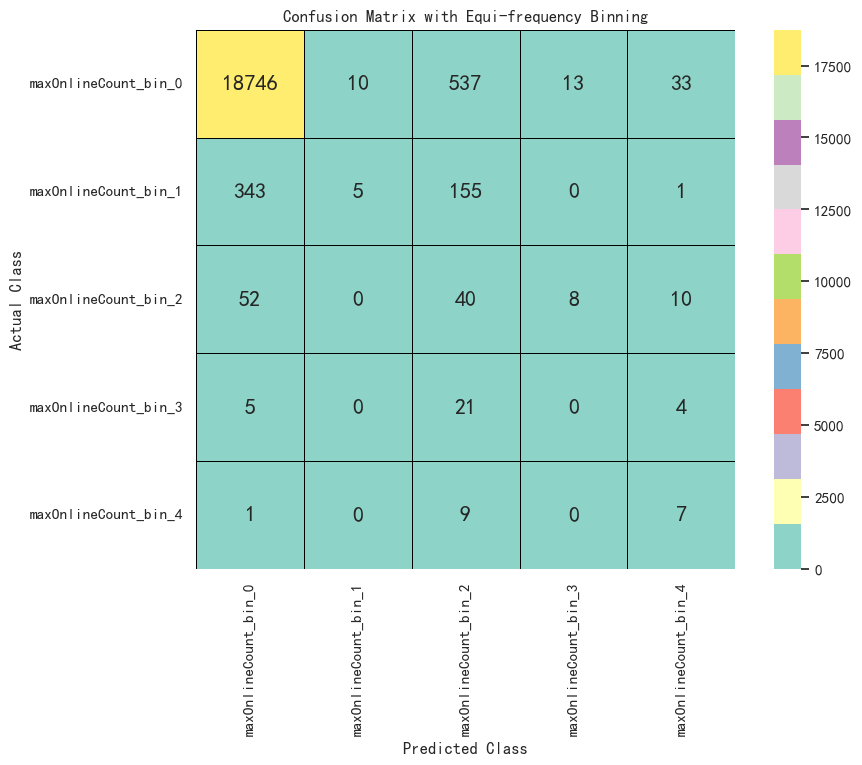

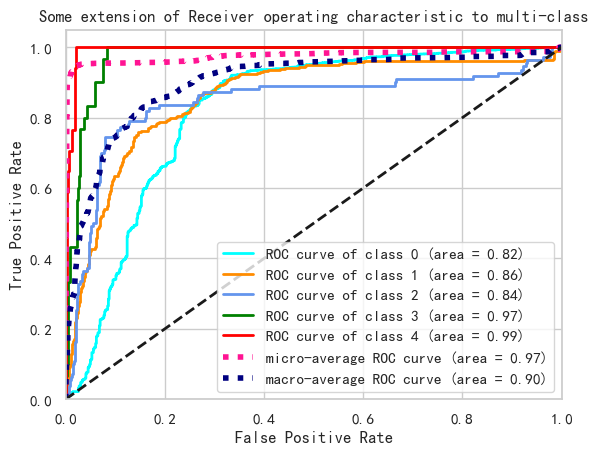

[0. 1. 2. 3. 4.]
Accuracy of CRT: 0.9712
Classification report for CRT:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     19339
         1.0       0.52      0.53      0.53       504
         2.0       0.49      0.45      0.47       110
         3.0       0.52      0.57      0.54        30
         4.0       0.58      0.65      0.61        17

    accuracy                           0.97     20000
   macro avg       0.62      0.64      0.63     20000
weighted avg       0.97      0.97      0.97     20000

Confusion Matrix for CRT:
[[19078   225    26     6     4]
 [  214   268    21     1     0]
 [   33    19    50     7     1]
 [    4     2     4    17     3]
 [    2     1     1     2    11]]


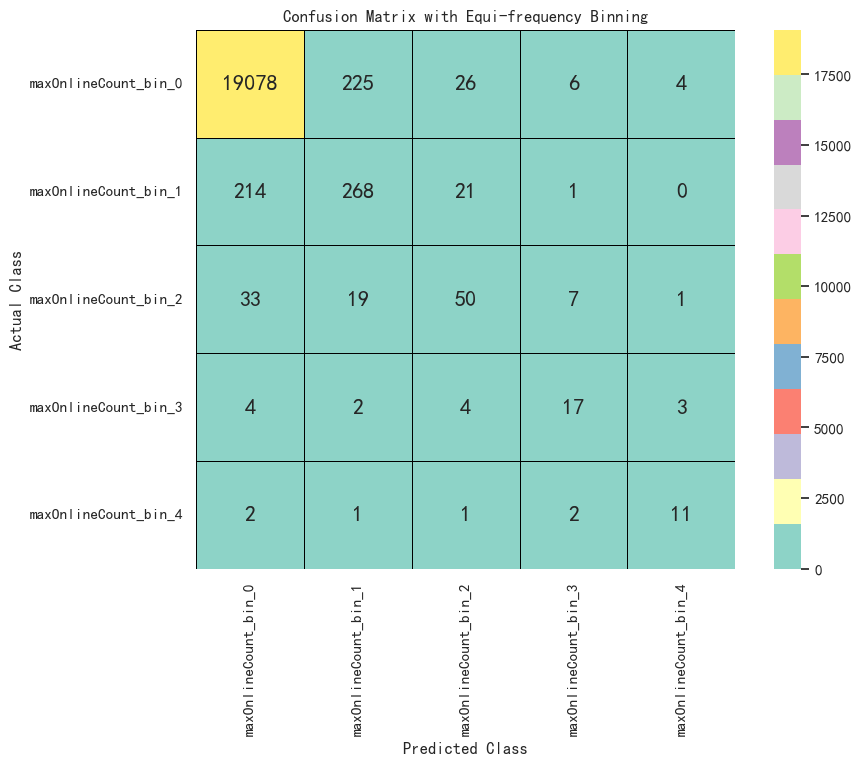

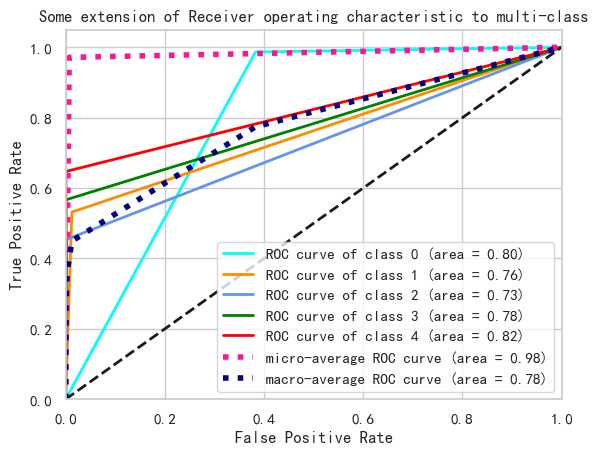

[0. 1. 2. 3. 4.]
Accuracy of LogisticRegression: 0.81485
Classification report for LogisticRegression:
              precision    recall  f1-score   support

         0.0       0.96      0.84      0.90     19339
         1.0       0.00      0.00      0.00       504
         2.0       0.00      0.11      0.01       110
         3.0       0.00      0.00      0.00        30
         4.0       0.00      0.00      0.00        17

    accuracy                           0.81     20000
   macro avg       0.19      0.19      0.18     20000
weighted avg       0.93      0.81      0.87     20000

Confusion Matrix for LogisticRegression:
[[16285    21  3031     0     2]
 [  471     0    33     0     0]
 [   98     0    12     0     0]
 [   28     0     2     0     0]
 [   14     0     3     0     0]]


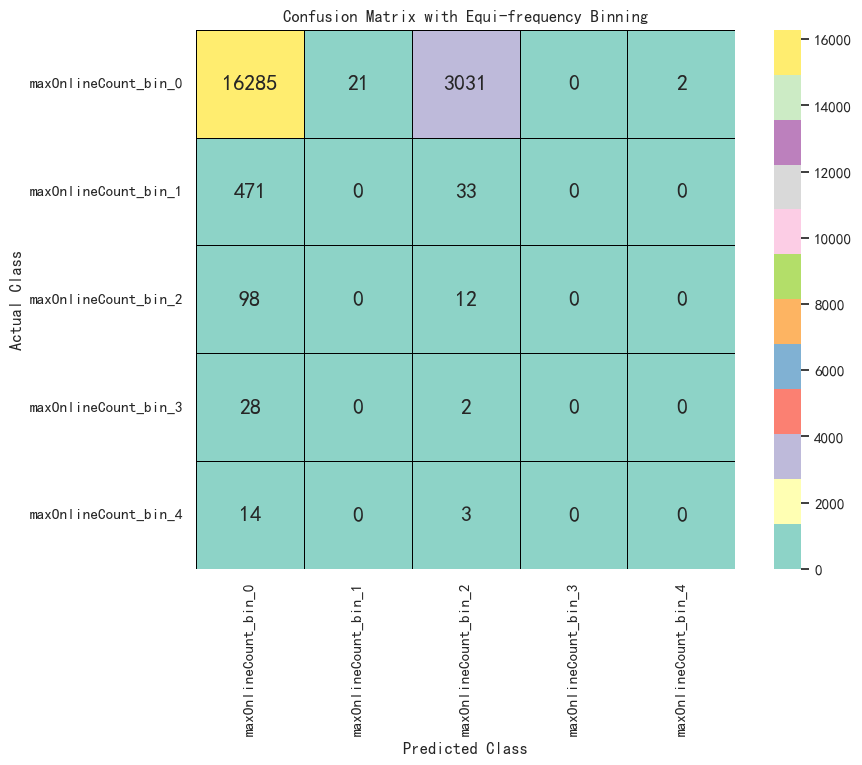

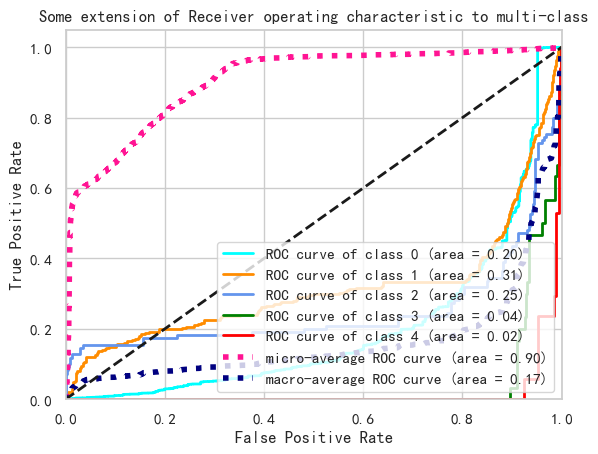

[0. 1. 2. 3. 4.]
Accuracy of MLPClassifier: 0.9607
Classification report for MLPClassifier:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     19339
         1.0       0.29      0.01      0.02       504
         2.0       0.16      0.59      0.25       110
         3.0       0.00      0.00      0.00        30
         4.0       0.46      0.35      0.40        17

    accuracy                           0.96     20000
   macro avg       0.38      0.39      0.33     20000
weighted avg       0.95      0.96      0.95     20000

Confusion Matrix for MLPClassifier:
[[19139     8   191     0     1]
 [  388     4   111     0     1]
 [   41     2    65     0     2]
 [    4     0    23     0     3]
 [    1     0    10     0     6]]


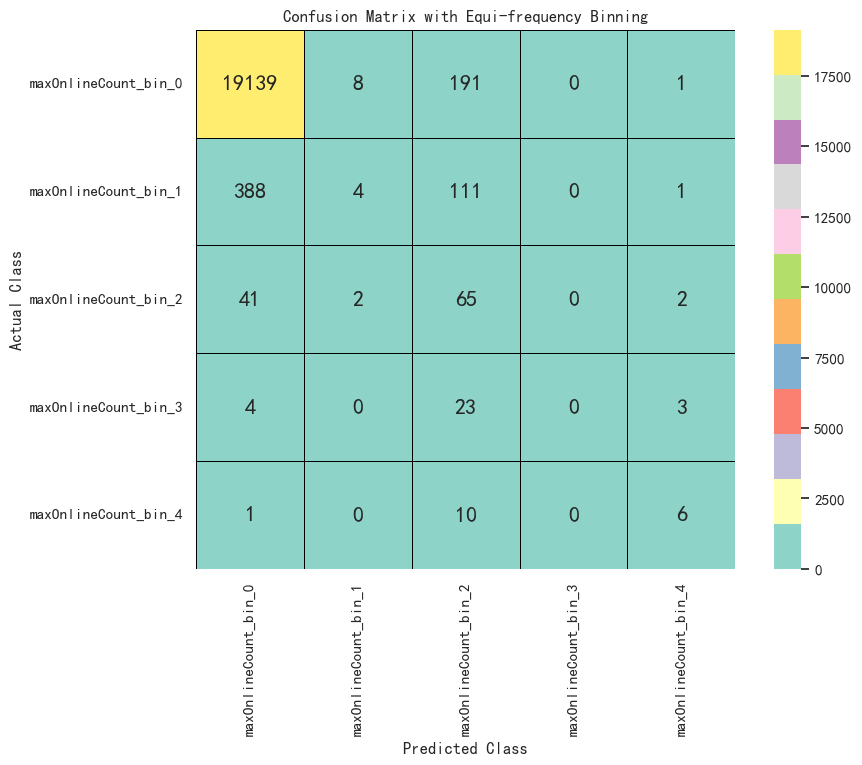

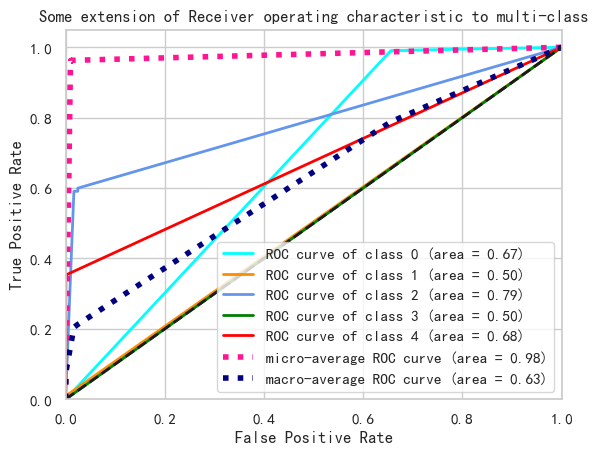

[0. 1. 2. 3. 4.]
Accuracy of RandomForestClassifier: 0.9803
Classification report for RandomForestClassifier:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     19339
         1.0       0.74      0.54      0.62       504
         2.0       0.70      0.52      0.59       110
         3.0       0.79      0.50      0.61        30
         4.0       0.80      0.71      0.75        17

    accuracy                           0.98     20000
   macro avg       0.80      0.65      0.71     20000
weighted avg       0.98      0.98      0.98     20000

Confusion Matrix for RandomForestClassifier:
[[19250    73    13     1     2]
 [  225   272     7     0     0]
 [   26    24    57     3     0]
 [    9     1     4    15     1]
 [    4     0     1     0    12]]


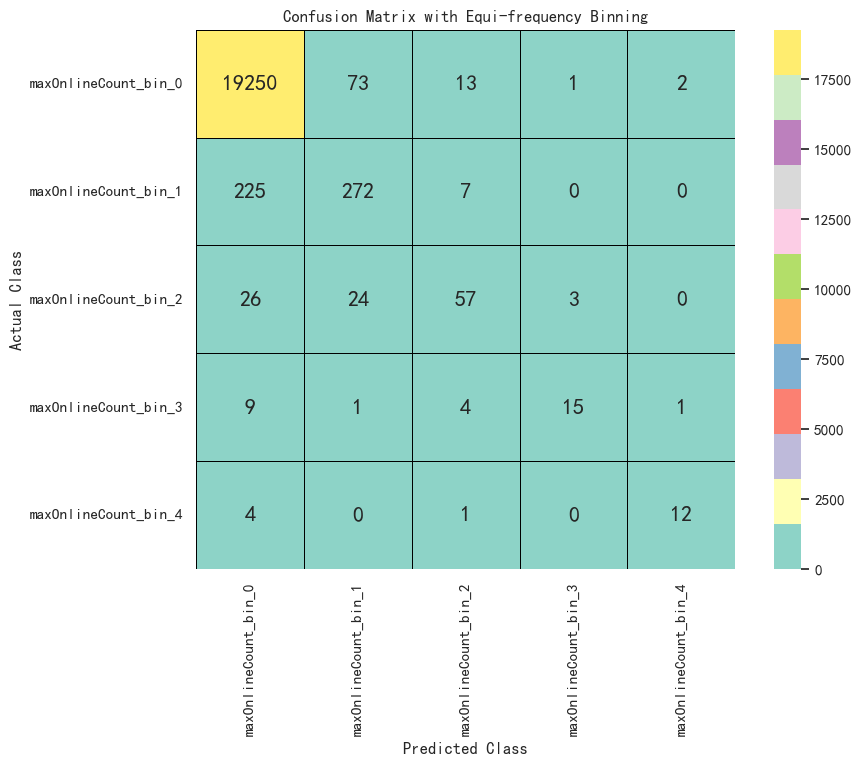

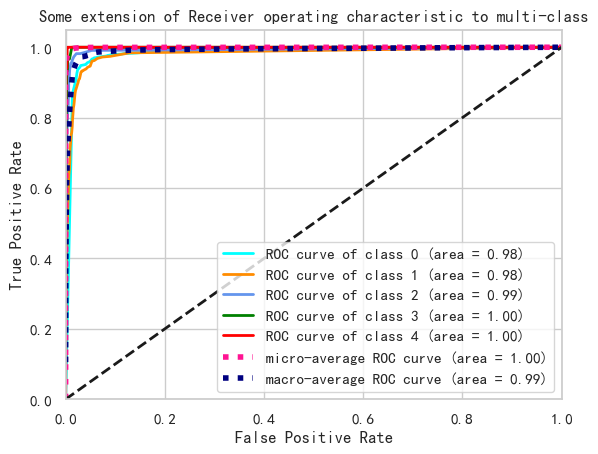

[0. 1. 2. 3. 4.]
Accuracy of KNeighborsClassifier: 0.9779
Classification report for KNeighborsClassifier:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     19339
         1.0       0.67      0.58      0.63       504
         2.0       0.59      0.45      0.51       110
         3.0       0.65      0.37      0.47        30
         4.0       0.71      0.71      0.71        17

    accuracy                           0.98     20000
   macro avg       0.72      0.62      0.66     20000
weighted avg       0.98      0.98      0.98     20000

Confusion Matrix for KNeighborsClassifier:
[[19191   120    19     4     5]
 [  203   294     7     0     0]
 [   40    19    50     1     0]
 [    9     1     9    11     0]
 [    2     2     0     1    12]]


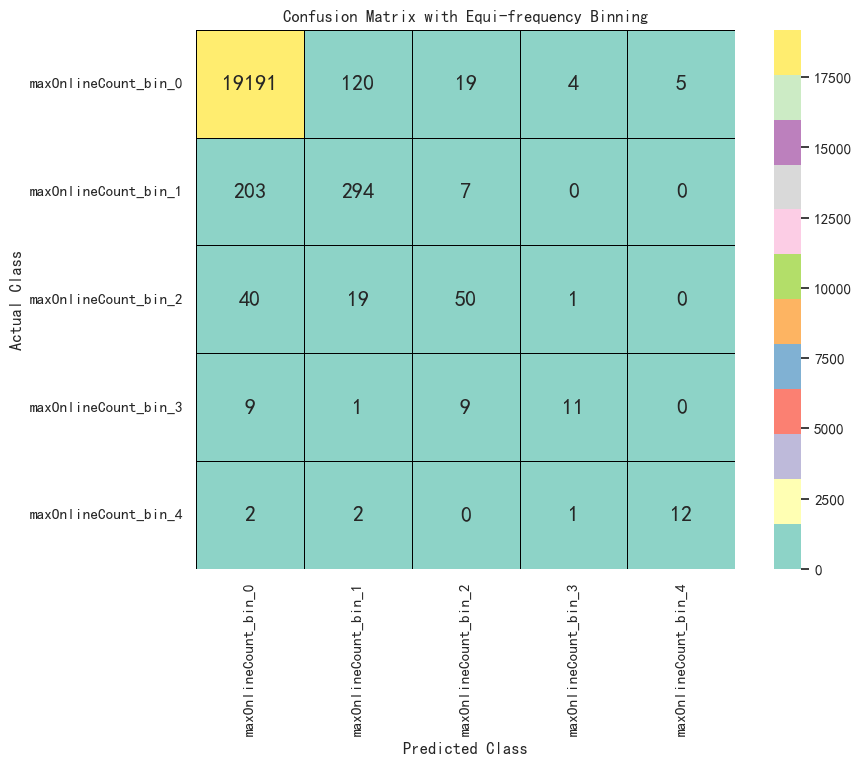

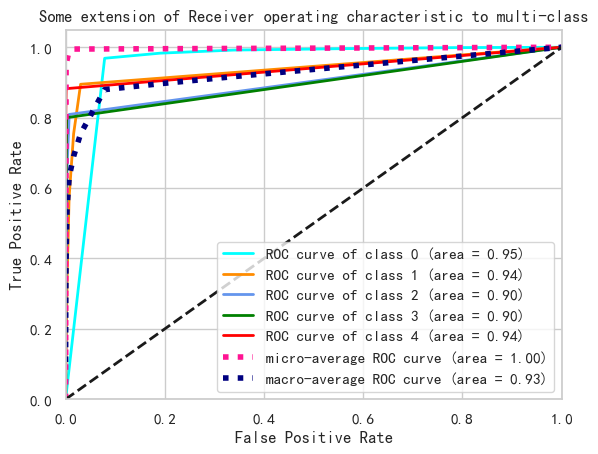

In [20]:
train_evaluate_classifier(classifiers, "maxOnlineCount", strategy="kmeans")

### 把totalIncome作为y

[0. 1. 2. 3. 4.]
Accuracy of GaussianNB: 0.9359
Classification report for GaussianNB:
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     19077
         1.0       0.24      0.03      0.05       788
         2.0       0.00      0.00      0.00       119
         3.0       0.01      0.33      0.02        15
         4.0       0.00      0.00      0.00         1

    accuracy                           0.94     20000
   macro avg       0.24      0.27      0.21     20000
weighted avg       0.93      0.94      0.93     20000

Confusion Matrix for GaussianNB:
[[18691    65     0   262    59]
 [  595    22     0   147    24]
 [   76     5     0    31     7]
 [   10     0     0     5     0]
 [    0     0     0     1     0]]


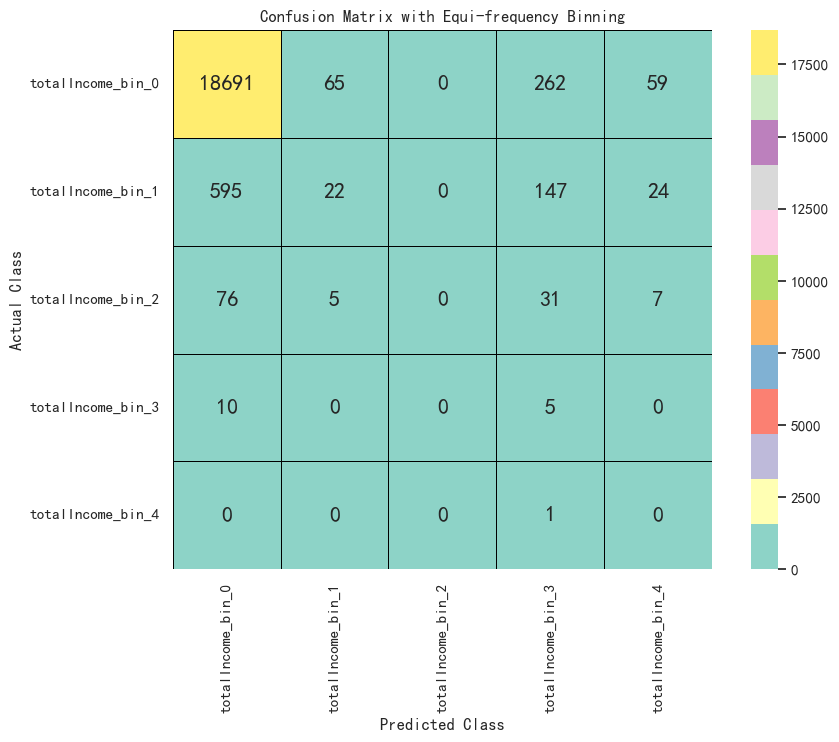

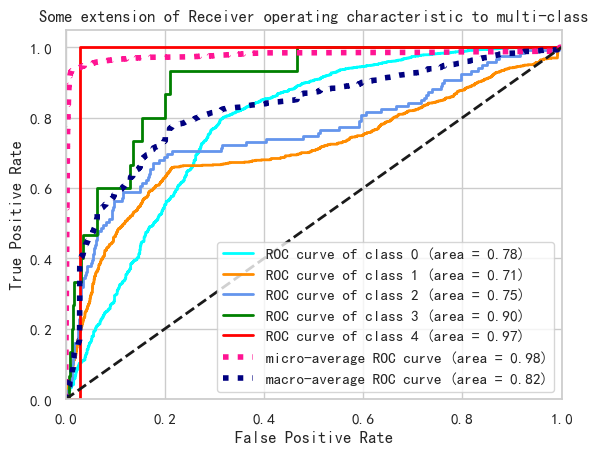

[0. 1. 2. 3. 4.]
Accuracy of CRT: 0.9389
Classification report for CRT:
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97     19077
         1.0       0.32      0.35      0.33       788
         2.0       0.16      0.18      0.17       119
         3.0       0.00      0.00      0.00        15
         4.0       0.00      0.00      0.00         1

    accuracy                           0.94     20000
   macro avg       0.29      0.30      0.29     20000
weighted avg       0.94      0.94      0.94     20000

Confusion Matrix for CRT:
[[18483   537    54     3     0]
 [  461   274    52     1     0]
 [   43    50    21     4     1]
 [    3     8     4     0     0]
 [    0     0     0     1     0]]


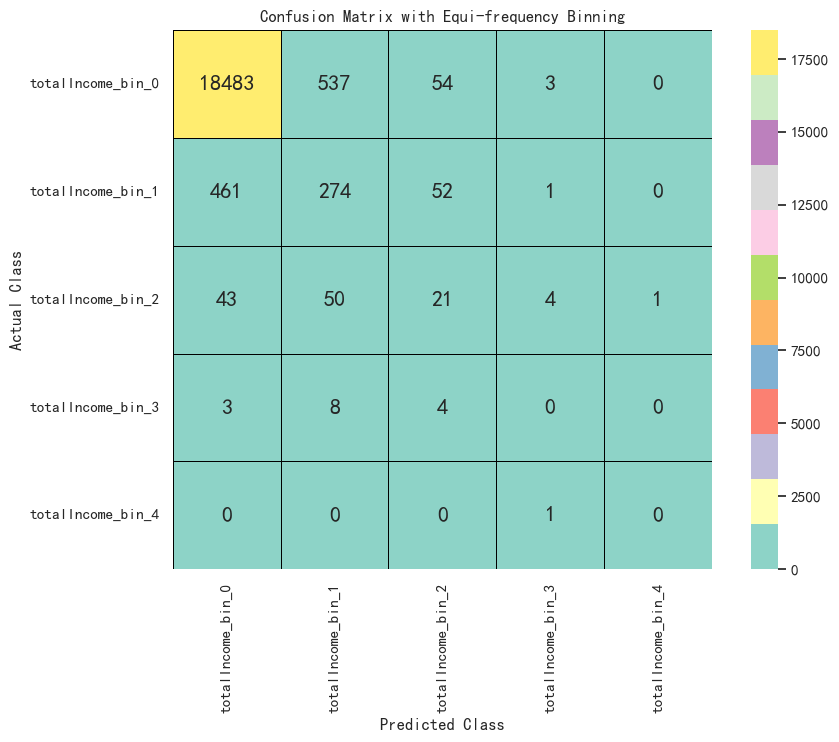

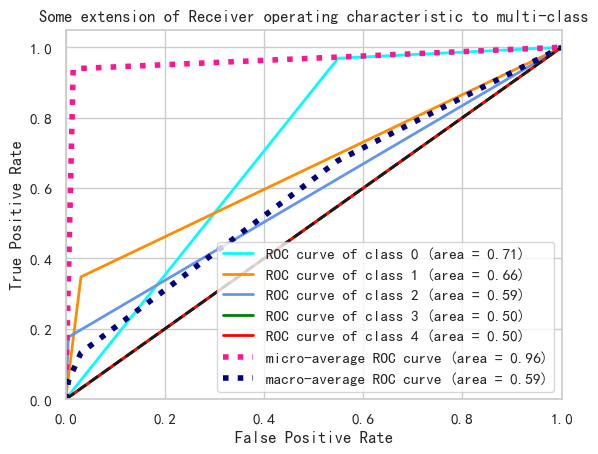

[0. 1. 2. 3. 4.]
Accuracy of LogisticRegression: 0.91905
Classification report for LogisticRegression:
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96     19077
         1.0       0.00      0.00      0.00       788
         2.0       0.00      0.00      0.00       119
         3.0       0.00      0.00      0.00        15
         4.0       0.00      0.00      0.00         1

    accuracy                           0.92     20000
   macro avg       0.19      0.19      0.19     20000
weighted avg       0.91      0.92      0.91     20000

Confusion Matrix for LogisticRegression:
[[18379   698     0     0     0]
 [  786     2     0     0     0]
 [  119     0     0     0     0]
 [   15     0     0     0     0]
 [    1     0     0     0     0]]


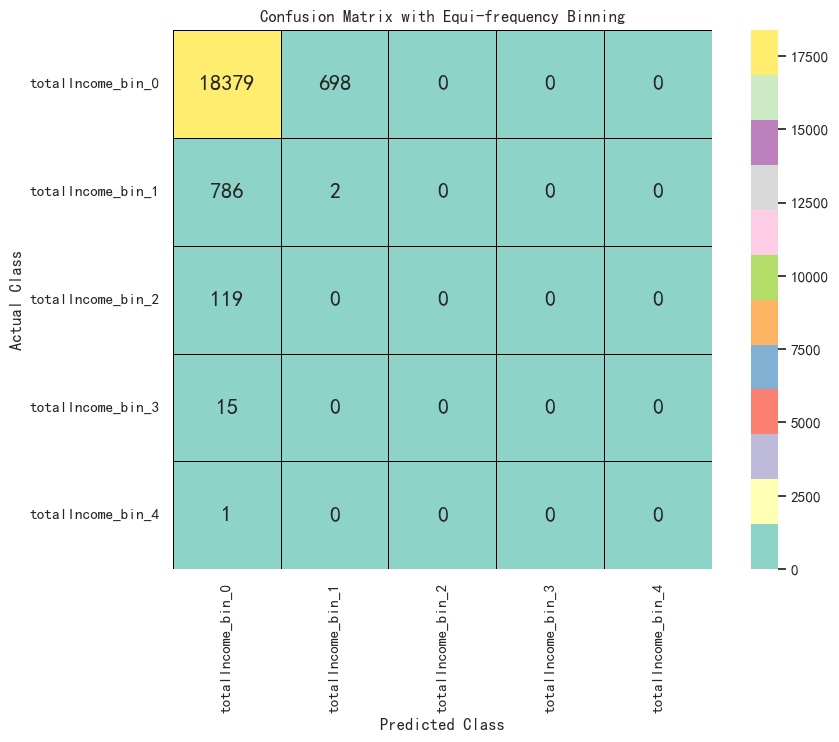

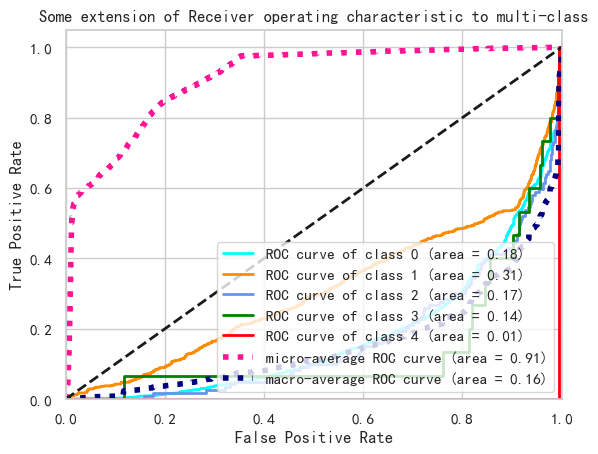

[0. 1. 2. 3. 4.]
Accuracy of MLPClassifier: 0.9489
Classification report for MLPClassifier:
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98     19077
         1.0       0.30      0.13      0.19       788
         2.0       0.12      0.02      0.03       119
         3.0       0.00      0.00      0.00        15
         4.0       0.00      0.00      0.00         1

    accuracy                           0.95     20000
   macro avg       0.28      0.23      0.24     20000
weighted avg       0.93      0.95      0.94     20000

Confusion Matrix for MLPClassifier:
[[18870   189     9     9     0]
 [  672   106     6     4     0]
 [   72    43     2     2     0]
 [    6     9     0     0     0]
 [    0     1     0     0     0]]


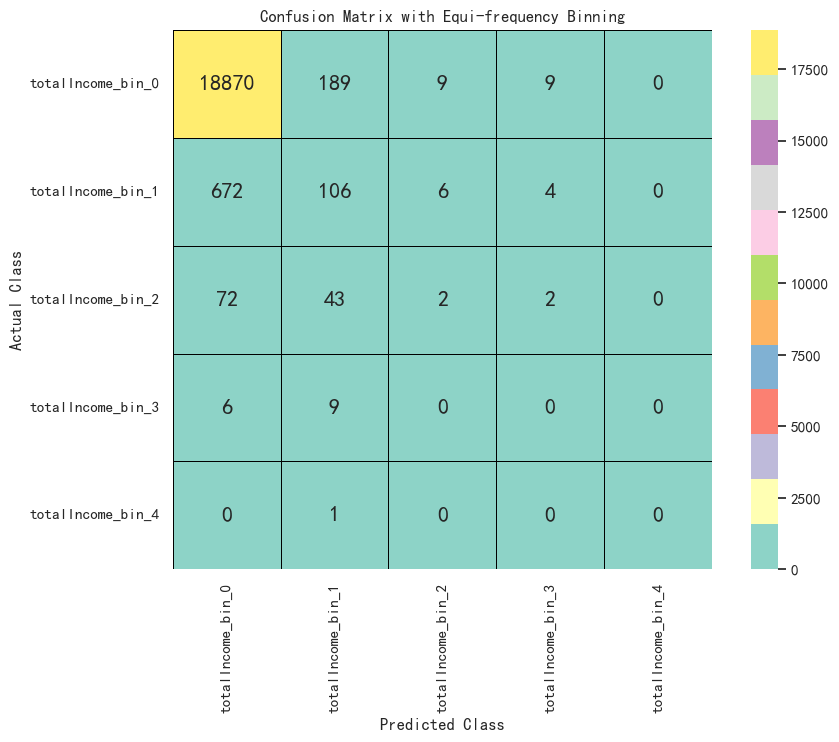

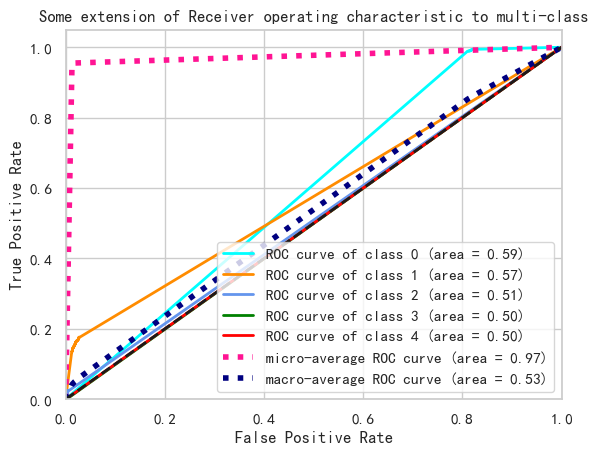

[0. 1. 2. 3. 4.]
Accuracy of RandomForestClassifier: 0.9611
Classification report for RandomForestClassifier:
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     19077
         1.0       0.61      0.27      0.37       788
         2.0       0.52      0.13      0.20       119
         3.0       0.00      0.00      0.00        15
         4.0       0.00      0.00      0.00         1

    accuracy                           0.96     20000
   macro avg       0.42      0.28      0.31     20000
weighted avg       0.95      0.96      0.95     20000

Confusion Matrix for RandomForestClassifier:
[[18994    83     0     0     0]
 [  563   213    11     1     0]
 [   59    45    15     0     0]
 [    2    10     3     0     0]
 [    0     1     0     0     0]]


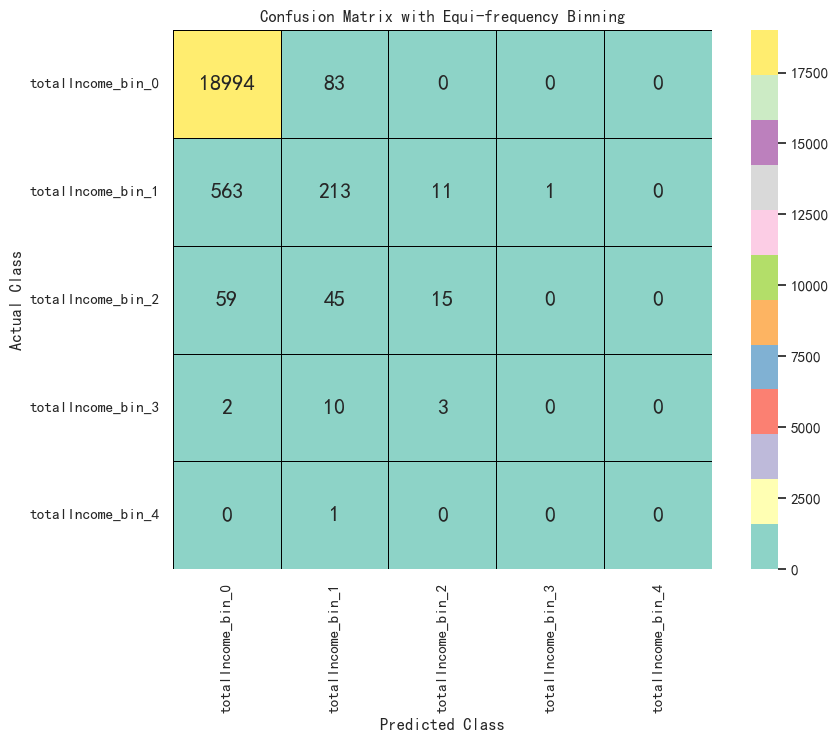

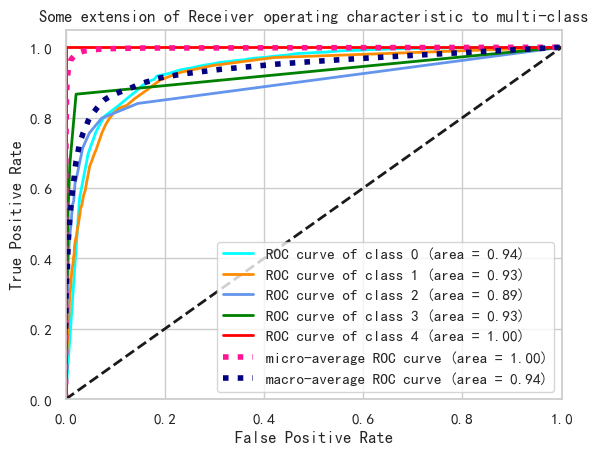

[0. 1. 2. 3. 4.]
Accuracy of KNeighborsClassifier: 0.95575
Classification report for KNeighborsClassifier:
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98     19077
         1.0       0.49      0.19      0.27       788
         2.0       0.62      0.08      0.15       119
         3.0       0.00      0.00      0.00        15
         4.0       0.00      0.00      0.00         1

    accuracy                           0.96     20000
   macro avg       0.41      0.25      0.28     20000
weighted avg       0.94      0.96      0.94     20000

Confusion Matrix for KNeighborsClassifier:
[[18958   117     2     0     0]
 [  638   147     3     0     0]
 [   78    31    10     0     0]
 [    8     6     1     0     0]
 [    0     1     0     0     0]]


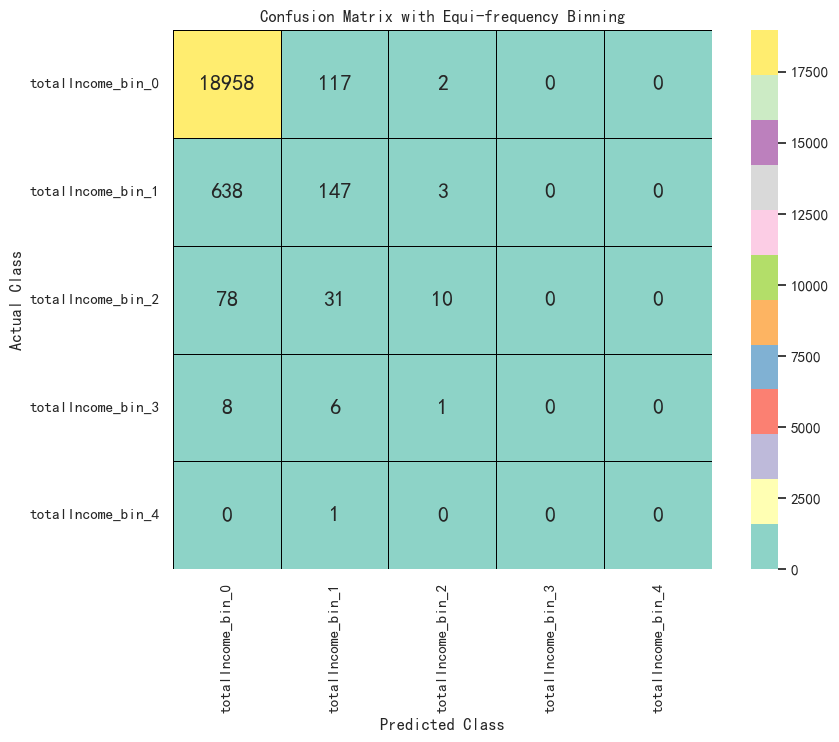

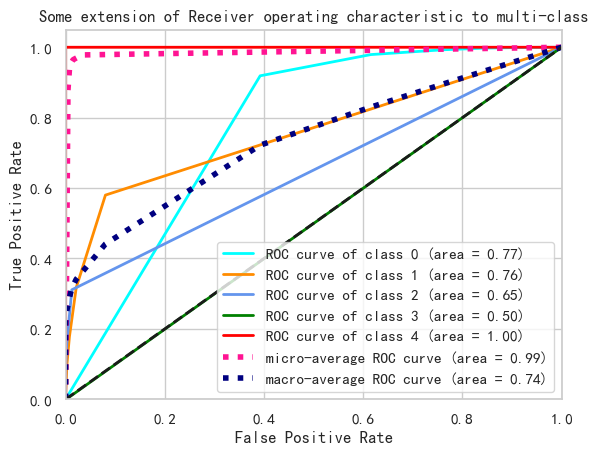

In [21]:
train_evaluate_classifier(classifiers, "totalIncome", strategy="kmeans")

### 神经网络-基于keras

In [24]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
# 数据预处理 - cut
# sample_cdr_x['income_bin'] = pd.cut(sample_cdr_x['totalIncome'], 5, labels=False)
# X = sample_cdr_x.drop(['totalIncome', 'income_bin'], axis=1)
# y = sample_cdr_x['income_bin']


# KBins
def nn_train(sample_cdr_x, variable_name, strategy="kmeans"):
    # 对目标变量进行等频分箱,先取对数再加一，用KBinsDiscretizer进行分箱
    sample_cdr_x[f"{variable_name}_bin"] = KBinsDiscretizer(
        n_bins=5, encode="ordinal", strategy=strategy
    ).fit_transform(sample_cdr_x[[variable_name]])
    print(sample_cdr_x[f"{variable_name}_bin"].sort_values().unique())
    _X = sample_cdr_x.drop([f"{variable_name}_bin", variable_name], axis=1)  # 特征变量
    _y = sample_cdr_x[f"{variable_name}_bin"]  # 目标变量
    X_train, X_test, y_train, y_test = train_test_split(
        _X, _y, test_size=0.2, random_state=42
    )
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    num_classes = len(np.unique(_y))
    print(f"Number of classes: {num_classes}")
    # 标签独热编码
    y_train = to_categorical(y_train, num_classes=num_classes)
    y_test = to_categorical(y_test, num_classes=num_classes)

    # 构建模型
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(
                256, activation="relu", input_shape=(X_train.shape[1],)
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(16, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(num_classes, activation="softmax"),
        ]
    )

    # 编译模型
    model.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )

    @tf.function
    def train_step(x, y):
        with tf.GradientTape() as tape:
            predictions = model(x, training=True)
            loss = tf.keras.losses.categorical_crossentropy(y, predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss

    # 训练模型
    optimizer = tf.keras.optimizers.Adam()
    epochs = 100
    batch_size = 64

    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            x_batch = X_train[i : i + batch_size]
            y_batch = y_train[i : i + batch_size]
            loss = train_step(x_batch, y_batch)

        if epoch % 10 == 0:
            train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
            val_loss, val_accuracy = model.evaluate(X_test, y_test, verbose=0)
            print(
                f"Epoch {epoch}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}"
            )

    # 评估模型
    y_pred = model.predict(X_test)
    y_pred_classes = y_pred.argmax(axis=1)
    y_test_classes = y_test.argmax(axis=1)

    # 混淆矩阵
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    print(cm)
    print(classification_report(y_test_classes, y_pred_classes))
    # 标签二值化
    y_test_binarized = label_binarize(y_test_classes, classes=range(num_classes))

    # 获取每个类别的预测概率
    y_pred_prob = model.predict(X_test)

    # 计算每个类的ROC曲线和AUC值
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # 微平均 - 计算所有FP和所有TP
    fpr["micro"], tpr["micro"], _ = roc_curve(
        y_test_binarized.ravel(), y_pred_prob.ravel()
    )
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # 宏平均 - 计算所有类别的平均FPR, TPR
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= num_classes
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # 绘制所有ROC曲线
    plt.figure(figsize=(8, 6))
    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(num_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=2,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Extension of Receiver operating characteristic to multi-class")
    plt.legend(loc="lower right")
    plt.show()

[0. 1. 2. 3. 4.]
Number of classes: 5
Epoch 0, Train Loss: 0.14877848327159882, Train Accuracy: 0.9577749967575073, Validation Loss: 0.15335862338542938, Validation Accuracy: 0.9563999772071838
Epoch 10, Train Loss: 0.14092247188091278, Train Accuracy: 0.9572749733924866, Validation Loss: 0.14872053265571594, Validation Accuracy: 0.9559000134468079
Epoch 20, Train Loss: 0.14812634885311127, Train Accuracy: 0.956962525844574, Validation Loss: 0.15691980719566345, Validation Accuracy: 0.955299973487854
Epoch 30, Train Loss: 0.14411115646362305, Train Accuracy: 0.95746248960495, Validation Loss: 0.1533275693655014, Validation Accuracy: 0.9557499885559082
Epoch 40, Train Loss: 0.14800679683685303, Train Accuracy: 0.957087516784668, Validation Loss: 0.1570969521999359, Validation Accuracy: 0.9554499983787537
Epoch 50, Train Loss: 0.14984650909900665, Train Accuracy: 0.9571874737739563, Validation Loss: 0.15893693268299103, Validation Accuracy: 0.9555500149726868
Epoch 60, Train Loss: 0.1535

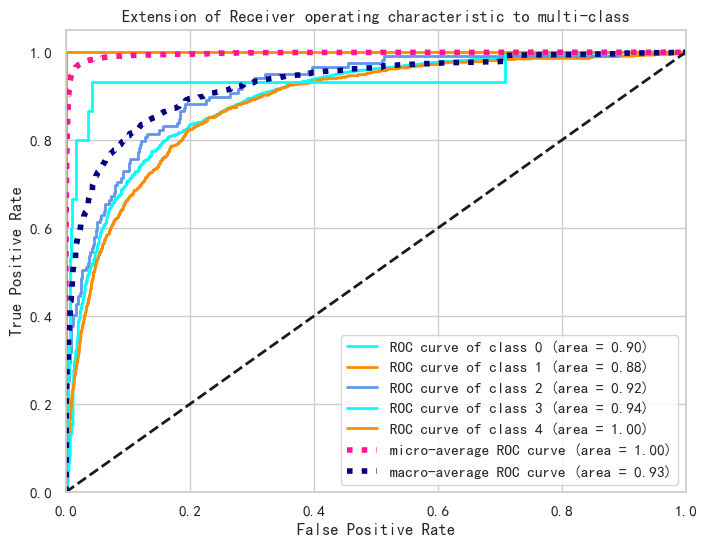

In [25]:
sample_income = sample_cdr[
    [
        "totalIncome",
        "live_time_last",
        "danmakusCount",
        "likeCount",
        "maxOnlineCount",
        "channel_totalIncome",
        "channel_totalLiveCount",
        "channel_lastLiveIncome",
        "hour_likeCount",
        "hour_watchCount",
    ]
]
nn_train(sample_income, "totalIncome")

[0. 1. 2. 3. 4.]
Number of classes: 5
Epoch 0, Train Loss: 0.10854146629571915, Train Accuracy: 0.9677000045776367, Validation Loss: 0.11419622600078583, Validation Accuracy: 0.9660500288009644
Epoch 10, Train Loss: 0.08517930656671524, Train Accuracy: 0.9686625003814697, Validation Loss: 0.09130419045686722, Validation Accuracy: 0.9671499729156494
Epoch 20, Train Loss: 0.0802353173494339, Train Accuracy: 0.9690499901771545, Validation Loss: 0.08560634404420853, Validation Accuracy: 0.967199981212616
Epoch 30, Train Loss: 0.08007249981164932, Train Accuracy: 0.9698125123977661, Validation Loss: 0.08570157736539841, Validation Accuracy: 0.9681000113487244
Epoch 40, Train Loss: 0.08101221919059753, Train Accuracy: 0.9702000021934509, Validation Loss: 0.0878210961818695, Validation Accuracy: 0.9681500196456909
Epoch 50, Train Loss: 0.08127325773239136, Train Accuracy: 0.9704124927520752, Validation Loss: 0.08830831199884415, Validation Accuracy: 0.9690499901771545
Epoch 60, Train Loss: 0.

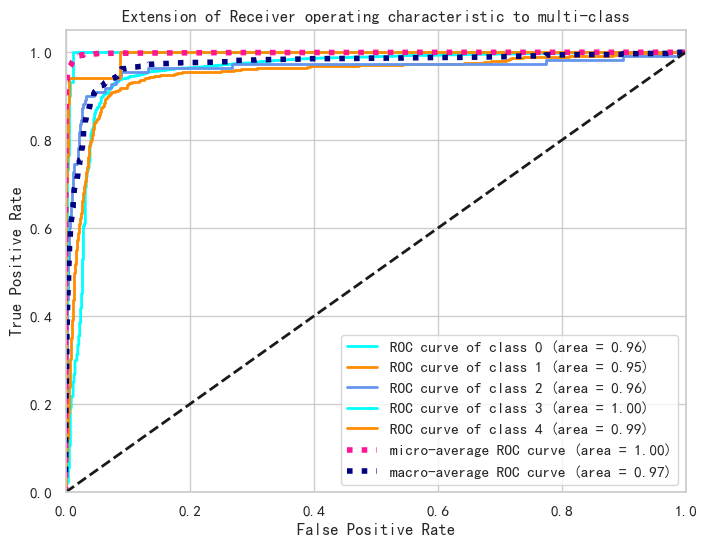

In [26]:
sample_maxonline = sample_cdr[
    [
        "totalIncome",
        "live_time_last",
        "danmakusCount",
        "likeCount",
        "maxOnlineCount",
        "channel_totalIncome",
        "channel_totalLiveCount",
        "channel_lastLiveIncome",
        "hour_likeCount",
        "hour_watchCount",
    ]
]
nn_train(sample_maxonline, "maxOnlineCount")

# 文本挖掘

In [31]:
print(
    sample_cdr["title"],
    sample_cdr["channel_uName"],
    sample_cdr["parentArea"],
    sample_cdr["channel_title"],
    sample_cdr["channel_tags"],
)

1258786    【工作音】小鸟会爱你的
1218281        真心换真心咯！
350417         LOLTime
604945          先当会潜水佬
122464        你们有什么烦恼吗
              ...     
173914        【B限】test
894896        少 儿 频  道
1371728        背叛者的直播间
55611      5.14 海拉鲁海拉鲁
96944       满级渔场，终于等到你
Name: title, Length: 100000, dtype: object 1258786        家雀爱恰西瓜
1218281       鹿卡上学不迟到
350417     草青Official
604945     上尾栗Ageoawa
122464        艾妮娅Enia
              ...    
173914          天音マリー
894896        甜崽Babys
1371728      臧贺Lunmta
55611      Kirikosama
96944            琉夏来了
Name: channel_uName, Length: 100000, dtype: object 1258786    虚拟主播
1218281    虚拟主播
350417       网游
604945     虚拟主播
122464     虚拟主播
           ... 
173914     虚拟主播
894896     虚拟主播
1371728      手游
55611      单机游戏
96944        电台
Name: parentArea, Length: 100000, dtype: object 1258786            不许笑！！！
1218281           血染钟楼回归！
350417            FSN-HF线
604945     黑轩命令我借他的W玩一把肉鸽
122464            配音pia戏娅
                ...      
173914          b限/看视频＋雑談
89489

In [19]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

text_fields = ["title", "channel_uName", "parentArea", "channel_title", "channel_tags"]
# 将所有文本字段合并成一个大的字符串，每一条直播的所有信息合成一个文本
# 使用lambda函数和map函数将每个元素转换为字符串，然后再进行拼接
sample_text = (
    sample_cdr[text_fields].fillna("").apply(lambda x: " ".join(map(str, x)), axis=1)
)
# 使用CountVectorizer将文本数据转换为文档-词频（DTM）矩阵
count_vect = CountVectorizer(max_df=0.95, min_df=2, stop_words="chinese")
dtm = count_vect.fit_transform(sample_text)

# 构建LDA模型
num_topics = 5
lda = LatentDirichletAllocation(n_components=num_topics, random_state=0)
lda.fit(dtm)


# 显示每个主题的顶部词汇
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join(
            [feature_names[i] for i in topic.argsort()[: -n_top_words - 1 : -1]]
        )
        print(message)


print_top_words(lda, count_vect.get_feature_names_out(), n_top_words=10)

# 为了提取TF-IDF关键词，我们再次将样本文本转换成TF-IDF矩阵
tfidf_vect = TfidfVectorizer()
tfidf = tfidf_vect.fit_transform(sample_text)

# 获取每篇文档的特征词
tfidf_feature_names = tfidf_vect.get_feature_names_out()
for i in range(tfidf.shape[0]):
    tfidf_sorting = (-tfidf[i].toarray()[0]).argsort()
    top_n = tfidf_sorting[:3]  # 提取前3个关键词
    print(f"Document {i} top words: {tfidf_feature_names[top_n]}")

InvalidParameterError: The 'stop_words' parameter of CountVectorizer must be a str among {'english'}, an instance of 'list' or None. Got 'chinese' instead.

In [49]:
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

df_all = cdr.sample(n=200000, random_state=42)

df_all["combined_text"] = df_all[text_fields].apply(
    lambda x: " ".join(map(str, x)), axis=1
)

# 使用jieba进行中文分词
df_all["cutted_text"] = df_all["combined_text"].apply(lambda x: " ".join(jieba.cut(x)))


def replace_empty_list_with_none(tag_list):
    if isinstance(tag_list, list) and len(tag_list) == 0:
        return None
    else:
        return tag_list


# 应用函数到'channel_tags'列
df_all["channel_tags"] = df_all["channel_tags"].apply(replace_empty_list_with_none)
# 带有channel_tags的数据用于训练
train_data = df_all.dropna(subset=["channel_tags"])
# channel_tags为空的数据，用于预测
predict_data = df_all[df_all["channel_tags"].isnull()]

# 提取带标签的数据，并创建特征向量

tfidf_vect = TfidfVectorizer(max_features=1000)
X = tfidf_vect.fit_transform(train_data["cutted_text"])

# 将标签列表转换为二进制的多标签形式
multilabel_binarizer = MultiLabelBinarizer()
Y = multilabel_binarizer.fit_transform(train_data["channel_tags"])

# 划分训练集与测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42
)

# 使用OneVsRest策略的多标签分类器
ocl = OneVsRestClassifier(MultinomialNB())
ocl.fit(X_train, y_train)

# 在测试集上预测标签
y_pred = ocl.predict(X_test)

# 计算准确率
print(classification_report(y_test, y_pred, target_names=multilabel_binarizer.classes_))

if not predict_data.empty:
    X_predict = tfidf_vect.transform(predict_data["cutted_text"])
    predicted_tags = ocl.predict(X_predict)
    predict_data["predicted_tags"] = multilabel_binarizer.inverse_transform(
        predicted_tags
    )
    print(predict_data[["combined_text", "predicted_tags"]])
else:
    print("没有未标记的样本可用于预测。")

                precision    recall  f1-score   support

     #12月新星整活#       0.00      0.00      0.00        12
     #Tsunashi       0.00      0.00      0.00         0
      #Tsuna画廊       0.00      0.00      0.00         0
       #ichigo       0.00      0.00      0.00         3
           #声优       0.00      0.00      0.00         3
        #犬塚いちご       0.00      0.00      0.00         3
           #犬属       0.00      0.00      0.00         3
      #猫芒bell#       1.00      1.00      1.00        45
       #猫芒照相馆#       1.00      1.00      1.00        45
      #虚拟游戏玩家#       0.00      0.00      0.00        12
         #饼干露#       0.00      0.00      0.00        16
          ****       0.00      0.00      0.00         8
          **游戏       0.00      0.00      0.00        13
           **社       0.00      0.00      0.00        21
           **音       0.00      0.00      0.00         4
         *企鹅崽子       0.00      0.00      0.00         9
          *莓大福       0.00      0.00      0.00  

C:\Users\棒\AppData\Local\Temp\ipykernel_2440\934657825.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  bilibili_mask = imageio.imread('bilibili.png')


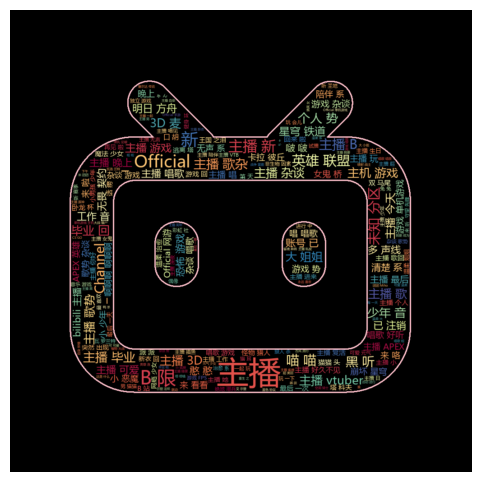

In [35]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import imageio
import numpy as np
import jieba

text = cdr[text_fields].fillna("").apply(lambda x: " ".join(map(str, x)), axis=1)

text = " ".join(text)

# 停用词列表
stop_words = [
    "的",
    "了",
    "在",
    "是",
    "我",
    "有",
    "和",
    "就",
    "不",
    "人",
    "都",
    "一",
    "一个",
    "上",
    "也",
    "很",
    "到",
    "说",
    "要",
    "去",
    "你",
    "会",
    "着",
    "看",
    "好",
    "自己",
    "这",
    "吧",
    "还",
    "不是",
    "但",
    "我们",
    "啊",
    "有点",
    "这个",
    "那",
    "那个",
    "这样",
    "这么",
    "这里",
    "那里",
    "这些",
    "那些",
    "这种",
    "那种",
    "这么多",
    "那么多",
    "这么样",
    "那么样",
    "这么点",
    "那么点",
    "这么些",
    "那么些",
    "这么着",
    "那么着",
    "这么会",
    "那么会",
    "这么来",
    "那么来",
    "这么去",
    "那么去",
    "这么说",
    "那么说",
    "这么看",
    "那么看",
    "这么好",
    "那么好",
    "这么自己",
    "那么自己",
    "这么都",
    "那么都",
    "这么一个",
    "那么一个",
    "这么上",
    "那么上",
    "这么下",
    "那么下",
    "这么后",
    "那么后",
    "这么前",
    "那么前",
    "这么中",
    "那么中",
    "这么里",
    "那么里",
    "这么外",
    "那么外",
    "这么内",
    "那么内",
    "这么间",
    "那么间",
    "这么地",
    "那么地",
    "这么方",
    "那么方",
    "这么面",
    "那么面",
    "这么种",
    "那么种",
    "这么类",
    "那么类",
    "这么个",
    "那么个",
    "这么种",
    "那么种",
    "这主播",
    "直播间",
    "V",
    "VUP",
    "虚拟",
    "UP",
    "直播",
    "主",
    "播",
]

# 使用 jieba 进行中文分词
text = " ".join(jieba.cut(text))
# 加载Bilibili图标作为词云形状
bilibili_mask = imageio.imread("bilibili.png")

# 创建词云对象
wordcloud = WordCloud(
    font_path="msyh.ttc",  # 设置字体路径，确保包含中文字体
    stopwords=stop_words,
    background_color=None,
    mask=bilibili_mask,
    width=800,
    height=400,
    contour_width=2,
    contour_color="pink",
    colormap="Spectral",
).generate(text)

# 显示词云图
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

C:\Users\棒\AppData\Local\Temp\ipykernel_2440\672259784.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  bilibili_mask = imageio.imread('bilibili.png')


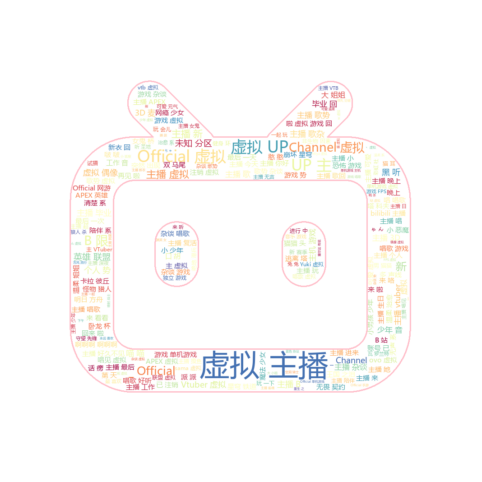

In [33]:
bilibili_mask = imageio.imread("bilibili.png")
if bilibili_mask.ndim == 3:  # 如果图像是彩色的，则转换为灰度图
    bilibili_mask = bilibili_mask[:, :, 0]

# 创建词云对象
wordcloud = WordCloud(
    font_path="msyh.ttc",  # 设置字体路径，确保包含中文字体
    stopwords=stop_words,
    background_color="white",  # 设置背景颜色为白色
    mask=bilibili_mask,
    contour_width=2,
    contour_color="pink",
    colormap="Spectral",
).generate(text)

# 显示词云图
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [51]:
new_texts = ["早起熬夜天下无敌 熬夜伤身早起痛苦 星舰"]  # 这里填写你的新文本数据
new_cutted_texts = [" ".join(jieba.cut(text)) for text in new_texts]
new_texts_transformed = tfidf_vect.transform(new_cutted_texts)
new_tags_pred = ocl.predict(new_texts_transformed)
# 将预测的二进制标签向量转换回标签列表
new_tags = multilabel_binarizer.inverse_transform(new_tags_pred)
print(new_tags)

[()]


In [45]:
print(sample_cdr["channel_tags"])

944440                                   [治愈少女音]
142662                  [VUP, 虚拟主播, Aliya, Lily]
74194                                         []
1027374                              [Vup, 虚拟主播]
652378                                [虚拟主播, 歌势]
                           ...                  
655704                                        []
33154                                         []
58573      [菜, 男孩子, 友军之敌, 低血压救星, 负重训练器材, 白给, 伪音]
698614      [虚拟主播, 徒花院紅Beni, 剑士, 美女, 帅哥, 搞笑, 唱歌]
1311919                                       []
Name: channel_tags, Length: 100000, dtype: object


(-1.099999951640449,
 1.0999989855096581,
 -1.0999999935553655,
 1.099999989578364)

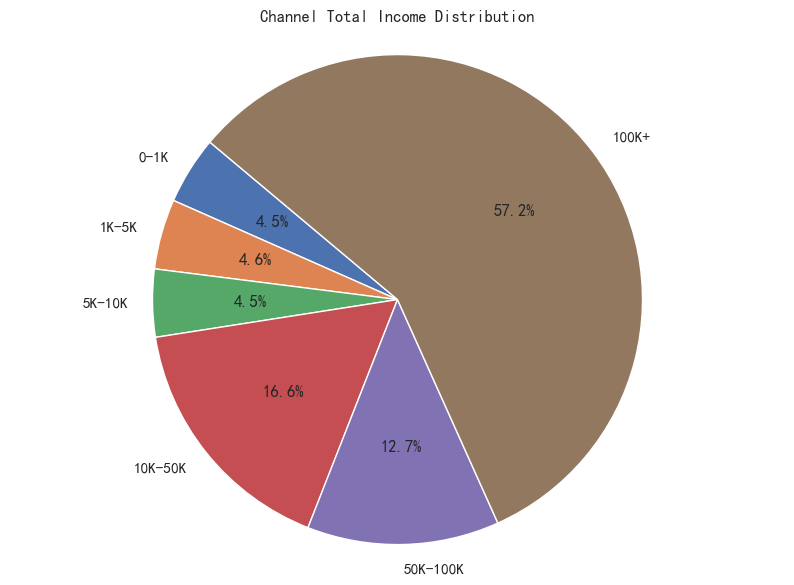

In [21]:
cdr["channel_totalIncome"] = pd.to_numeric(cdr["channel_totalIncome"], errors="coerce")

# 移除转换过程中变为 NaN 的行
cdr = cdr.dropna(subset=["channel_totalIncome"])
bins = [0, 1000, 5000, 10000, 50000, 100000, float("inf")]
labels = ["0-1K", "1K-5K", "5K-10K", "10K-50K", "50K-100K", "100K+"]

# 使用 pd.cut 进行分类
cdr["Income_Category"] = pd.cut(cdr["channel_totalIncome"], bins=bins, labels=labels)

# 按收入分类统计数量
income_counts = cdr["Income_Category"].value_counts().sort_index()

# 绘制饼图
plt.figure(figsize=(10, 7))
plt.pie(income_counts, labels=income_counts.index, autopct="%1.1f%%", startangle=140)
plt.title("Channel Total Income Distribution")
plt.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.